This latest version of the code provides a number of new effects.
1.  $\bf{DM\to \Delta f_\gamma}$. DM energy injection produces low energy photons that contribute to the blackbody distortion.
2.  $\bf{f_{exc,nl}\to \Delta f_\gamma}$. Some of that energy excites hydrogen atoms to the $nl$ excited state. These atoms then transition through many other excited states, producing or absorbing line photons that contribute to the distortion.
3.  $\bf{f_{exc,nl}\to \dot{x}_e}$. Sometimes these excited state transitions end in an ionization.
{4.  $\bf{f_{ion}\to \Delta f_\gamma}$. Extra ionization means extra photon absorption, and also an increase in recombinations, both of which affect the distortion.}
5. $\bf{\Delta f_\gamma \to \dot{x}_e}$. All rates -- recombination, ionization, and atomic transitions -- depend on the photon phase space density.  When $\Delta f_\gamma$ is non-zero, the rates change, and the ionization rate changes.
6. $\bf{\Delta f_\gamma \to \Delta f_\gamma}$. The distortion can be reprocessed over time, e.g. photons that are emitted at early times can be absorbed at later times.

In [1]:
import sys
sys.path.append('../..')

import config
import main
import pickle

import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d, interp2d

import darkhistory.physics as phys
from darkhistory.spec.spectra import Spectra
from darkhistory.spec.spectrum import Spectrum
import darkhistory.low_energy.atomic as atomic
import darkhistory.spec.spectools as spectools

In [2]:
import csv

def download_plot(file):
    with open('/Users/gregoryridgway/Desktop/Webplot_distortion/'+file+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        goods = []
        for row in reader:
            goods.append([float(r) for r in row])
            
        goods = np.array(goods)

    return goods

n10_data = download_plot('n10')
n20_data = download_plot('n20')
n30_data = download_plot('n30')
jens_data = download_plot('Full_Distortion')
jens_2s = download_plot('DeltaR_2s_jens')
jens_2p = download_plot('DeltaR_2p_jens')
BB_BF_jens = download_plot('BB_plus_BF_dist')

In [500]:
output_dir = '/Users/gregoryridgway/Desktop/Junk/'
input_dir = '/Users/gregoryridgway/Dropbox (MIT)/Late_Time_Energy_Injection/'

def plot_distortion(
    ax, run, run2=None,
    xlim=[4e-1, 1e6], ylim=[6e-30, 2e-26],
    label=None, color=None, title=None, alpha=1.0, leg=False,
    first=True, diff=False, rs_lim=None
):
    
    eng = run['distortion'].eng
    hplanck = phys.hbar * 2*np.pi
    nu = eng/hplanck
    convert = phys.nB * eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4
    
    ax.loglog()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if rs_lim is not None:
        dist_copy = run['distortions'].copy()
        dist_copy.redshift(rs_lim)
        distortion = dist_copy.sum_specs(run['rs'] >= rs_lim)
    else:
        distortion = run['distortion']
    
    if first:
        ax.plot(nu/1e9, np.ones_like(nu), color='k', 
            linestyle='solid', label='Positive Distortion')
        ax.plot(nu/1e9, np.ones_like(nu), color='k', 
            linestyle='--', label='Negative Distortion')
    
    if not diff:
        ax.plot(nu/1e9, convert * distortion.dNdE,
            color=color, linewidth=1.4,
            label=label, linestyle='solid', alpha=alpha)

        ax.plot(nu/1e9, -convert * distortion.dNdE,
            color=ax.get_lines()[-1].get_color(), linewidth=1.4,
            linestyle='--', alpha=alpha)
        
    else:
        ax.plot(nu/1e9, convert * (distortion.dNdE - run2['distortion'].dNdE),
            color=color, linewidth=1.4,
            label=label, linestyle='solid', alpha=alpha)

        ax.plot(nu/1e9, -convert * (distortion.dNdE - run2['distortion'].dNdE),
            color=ax.get_lines()[-1].get_color(), linewidth=1.4,
            linestyle='--', alpha=alpha)
    
#     ax.set_xticks([1e1,1e2,1e3,1e4,1e5,1e6])
    
    ax.set_xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
    ax.set_ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
    ax.set_title(title, fontsize=16)
    
    if leg:
        ax.legend()
        # leg = axarr[0].legend(fontsize=12, loc=1)
        # leg.set_title(r'$m_\chi = 200 MeV$, $\tau = 2 \times 10^{25}s$')
        # axarr[0].setp(leg.get_title(),fontsize='12')

In [3]:
%autoreload
def Gy(nu):
    return phys.ymu_distortion(nu, 1/4, phys.TCMB(1) / phys.kB, dist_type='y')

def y_dist_test(nu, result, mDM, lifetime, coarsen_factor=1):
    rs_list = result['rs']
    
    # nu is the frequencies in Hz over which to calculate the distortion
    weights = result['f']['heat'] * phys.inj_rate('decay', rs_list,
                                                  mDM=mDM, lifetime=lifetime)
    weights /= phys.CMB_eng_density(phys.TCMB(rs_list))
    
    weights[rs_list < 100] = 0
    return (
        Gy(nu) # Green's function
        * np.sum(weights * .001 * coarsen_factor / phys.hubble(rs_list)) # integrate over redshift
        * 1e4 * phys.ele # units of W / m^2 / ster / Hname
    )

# data1 = (
#     y_dist_test(nu, DM_run_withf, mDM, lifetime, coarsen_factor)
# )

In [4]:
from scipy.interpolate import interp2d
input_dir = config.data_path

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])

f_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

decay_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def param_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def param_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]
    
def param_bound(mDM, DM_process, pri):
    if pri == 'elec':
        return param_bound_elec_CMB(mDM, DM_process)
    else:
        return param_bound_phot_CMB(mDM, DM_process)

In [52]:
fig_dir = '/Users/gregoryridgway/Dropbox (MIT)/DarkHistory_V2/Drafts/figs/'
savefig=False

# 1. Distortion, DM component

In [1849]:
%%prun
%autoreload

pri = 'elec'
DM_process = 'decay'
mDM = 2e8
# mDM = 10**log10eng[::10][1] + phys.me
# mDM = 10**6.5
nmax=10

param = param_bound(mDM, DM_process, pri)
cf = 16  # coarsen_factor
string = str(int(np.floor(np.log10(mDM))))
start_rs = 3e3
end_rs = 5

baseline = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param*1e20,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf,
    distort=True, recfast_TLA=True, nmax=nmax
#     fexc_switch = False, 
)

DMrun = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf,
    distort=True, recfast_TLA=True,
    fexc_switch = False, 
    reprocess_distortion=False, 
    nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:675: RuntimeWarning: overflow encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:665: RuntimeWarning: invalid value encountered in double_scalars
  K[0][1] = BB_2s1s['up'] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:675: RuntimeWarning: divide by zero encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:695: RuntimeWarning: invalid value encountered in double_scalars
  b_exc[nl] /= tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/

# Reionization

In [1863]:
reion_strings = np.array(
    ['earliest', 'latest', 'FlexKnot_early', 'FlexKnot_late','FlexKnot_early_1sig', 'FlexKnot_late_1sig', 'Tanh_early', 'Tanh_late', 'Tanh_early_1sig', 'Tanh_late_1sig']
)

input_dir = '/Users/gregoryridgway/Dropbox (MIT)/Late_Time_Energy_Injection/'

def make_reion_interp_func(string, He_bump=False):
    Planck_data = []
    with open(input_dir+'/reion_models/Planck_'+
              string+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        reader = csv.reader(csvfile)
        for row in reader:
            Planck_data.append([float(row[0]),float(row[1])])
    Planck_data = np.array(Planck_data)

    #fix normalization
    if string == 'FlexKnot_early':
        norm_fac = Planck_data[-2,1]
    else:
        norm_fac = Planck_data[0,1]
        
        #I WebPlot Digitized poorly, so I re-zero
        if string == 'FlexKnot_late':
            Planck_data[26:,1] = 0
        elif string == 'Tanh_late':
            Planck_data[63:,1] = 0
            
        
    Planck_data[:,1] = (1+2*phys.chi)*Planck_data[:,1]/norm_fac

    #convert from z to rs
    Planck_data[:,0] = 1+Planck_data[:,0]

    fac = 2
    if He_bump == False:
        Planck_data[Planck_data[:,1]>1+phys.chi,1]=1+phys.chi
        fac = 1

    return interp1d(Planck_data[:,0], Planck_data[:,1], 
                    bounds_error=False, fill_value=(1+fac*phys.chi,0), kind='linear')

# Make interpolation functions for each Planck2018 reionization history
reion_interps = {string : make_reion_interp_func(string) for string in reion_strings}
bump_interp = make_reion_interp_func('Tanh_late', True)

In [1873]:
tmp = tla.get_history(
    baseline_reion['rs'][:-50], high_rs=1.555e3,
    reion_switch=True, reion_rs=30, xe_reion_func=reion_interps['FlexKnot_early'],
    rtol=1e-6
)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 350 but corresponding boolean dimension is 309

In [1868]:
%autoreload
# baseline_reion = main.evolve(
#     DM_process=DM_process, mDM=mDM,
#     lifetime=param*1e20,
#     sigmav=param,
#     primary=pri+'_delta',
#     start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
#     coarsen_factor=cf, 
#     reion_switch=True, reion_method='Puchwein', heat_switch=True,
#     distort=True, recfast_TLA=True, nmax=nmax
# #     fexc_switch = False, 
# )

baseline_reion_no_heat = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param*1e20,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf, 
    reion_switch=True, reion_method=None, heat_switch=True, reion_rs=30,
    xe_reion_func = reion_interps['FlexKnot_early'],
    distort=True, recfast_TLA=True, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:675: RuntimeWarning: overflow encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:665: RuntimeWarning: invalid value encountered in double_scalars
  K[0][1] = BB_2s1s['up'] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:675: RuntimeWarning: divide by zero encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:695: RuntimeWarning: invalid value encountered in double_scalars
  b_exc[nl] /= tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8296231490634D+01   r2 = -0.5093569466570D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8296231490634D+01   r2 = -0.5093569466570D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8296231490634D+01   r2 = -0.2341311211088D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8296231490634D+01   r2 = -0.2341311211088D-15
 lsoda--  warning..internal t (=r1) 

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/history/reionization.py:194: RuntimeWarning: overflow encountered in multiply
  return 2*alphaA_recomb('HII',T/4)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/history/reionization.py:256: RuntimeWarning: invalid value encountered in multiply
  + 1.036e-16 * T_m/phys.kB * alphaA_recomb('HeIII', T_m)
/usr/local/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


8.185526777580845 [           nan 7.60882983e-01 5.43939893e-14 0.00000000e+00]


ValueError: Encountered nan in Tm or x

In [873]:
DMrun_reion = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    reion_switch=True, reion_method='Puchwein', heat_switch=True,
    coarsen_factor=cf,
    distort=True, recfast_TLA=True,
    fexc_switch=False, 
    reprocess_distortion=False, 
    nmax=nmax,
    rtol=1e-6
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:594: RuntimeWarning: overflow encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:598: RuntimeWarning: overflow encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHist

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7318223210112D+01   r2 = -0.4204828962241D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7202063395333D+01   r2 = -0.2506175597394D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7087747348118D+01   r2 = -0.4113984074468D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7087747348118D+01   r2 = -0.9345371700706D-16
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6648342447945D+01   r2 = -0.8123915714094D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6648342447945D+01   r2 = -0.1845437674020D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6648342447945D+01   r2 = -0.3690875348040D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6648342447945D+01   r2 = -0.3690875348040D-17
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6236178454765D+01   r2 = -0.6227680498399D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6236178454765D+01   r2 = -0.1414686786271D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6236178454765D+01   r2 = -0.2829373572541D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6236178454765D+01   r2 = -0.2829373572541D-17
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5849566568535D+01   r2 = -0.5323656966839D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5849566568535D+01   r2 = -0.1209327801508D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5849566568535D+01   r2 = -0.2418655603017D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5849566568535D+01   r2 = -0.2418655603017D-17
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5486922686374D+01   r2 = -0.4555898180999D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5486922686374D+01   r2 = -0.1034922867015D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5486922686374D+01   r2 = -0.2069845734029D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5486922686374D+01   r2 = -0.2069845734029D-17
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5146760911857D+01   r2 = -0.3835730567974D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5146760911857D+01   r2 = -0.8713287959462D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5146760911857D+01   r2 = -0.1742657591892D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5146760911857D+01   r2 = -0.1742657591892D-17
 lsoda--  warning..internal t (=r1) 

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

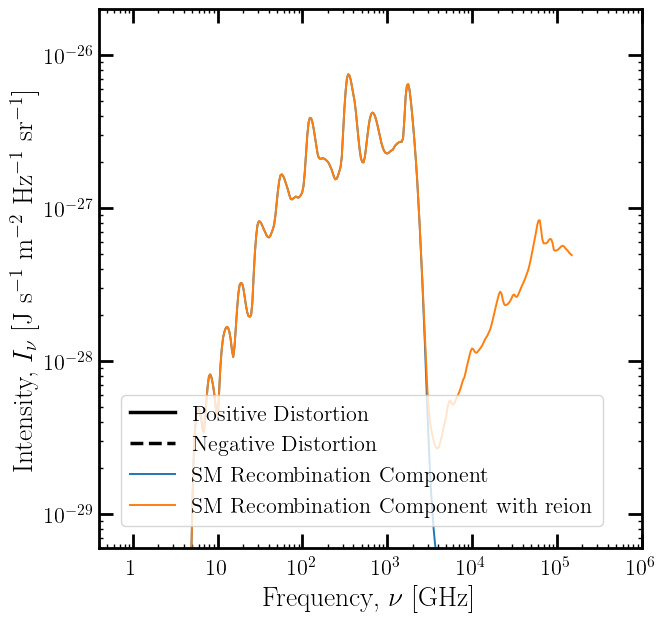

In [1858]:
plt.figure(figsize=(7, 7))
ax = plt.gca()

plot_distortion(ax, baseline, label='SM Recombination Component', leg=True)
plot_distortion(ax, baseline_reion, label='SM Recombination Component with reion',
                leg=True, first=False)

plot_distortion(ax, baseline_reion, label='SM Recombination Component with reion, no heat',
                leg=True, first=False)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

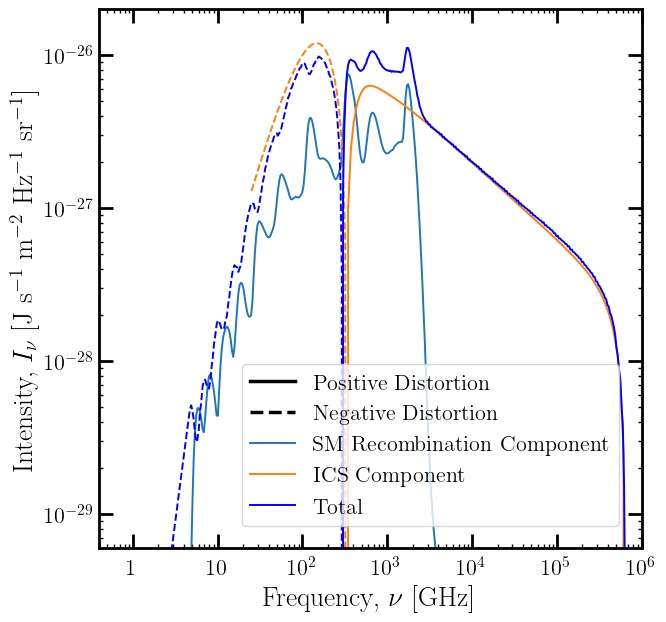

In [1850]:
# Interesting plots:
#    vary plot_distortion(rs_tmp = ...) to see the distortion as a function of z
#    include the different components, 2s, BF, ICS, etc.

plt.figure(figsize=(7, 7))
ax = plt.gca()

ICS_component = DMrun['lowengphot'].copy()
ICS_component._grid_vals *= list(map(int, ICS_component.eng < phys.rydberg))
ICS_component.redshift(1)
ICS_component = {'distortion': ICS_component.sum_specs()}

plot_distortion(ax, baseline, label='SM Recombination Component', leg=True)
plot_distortion(ax, ICS_component, label='ICS Component', first=False, leg=True)
plot_distortion(ax, DMrun, color='blue', label='Total', first=False, leg=True)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

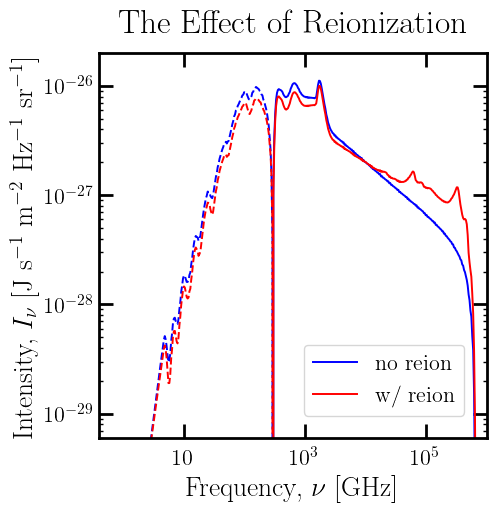

In [1659]:
plt.figure(figsize=(5, 5))
ax = plt.gca()

plot_distortion(ax, DMrun, color='blue', label='no reion', first=False, leg=True)
plot_distortion(ax, DMrun_reion, color='red', label='w/ reion', first=False, leg=True)
# plot_distortion(ax, DMrun_reion_withf, color='green', label='Total', first=False, leg=True)

plt.title('The Effect of Reionization')
plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

# 2. $f_{exc}$ as a distortion source

In [540]:
%autoreload
DMrun_withf = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=True,
    fexc_switch = True, reprocess_distortion=False, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:513: RuntimeWarning: overflow encountered in true_divide
  # !!! I should be able to set xHI = 1 - sum(x_full) - xe,
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:517: RuntimeWarning: overflow encountered in double_scalars
  
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhis

Text(0.5, 1.0, 'CMB Spectral Distortion due to DM Decay to $e^+e^-$')

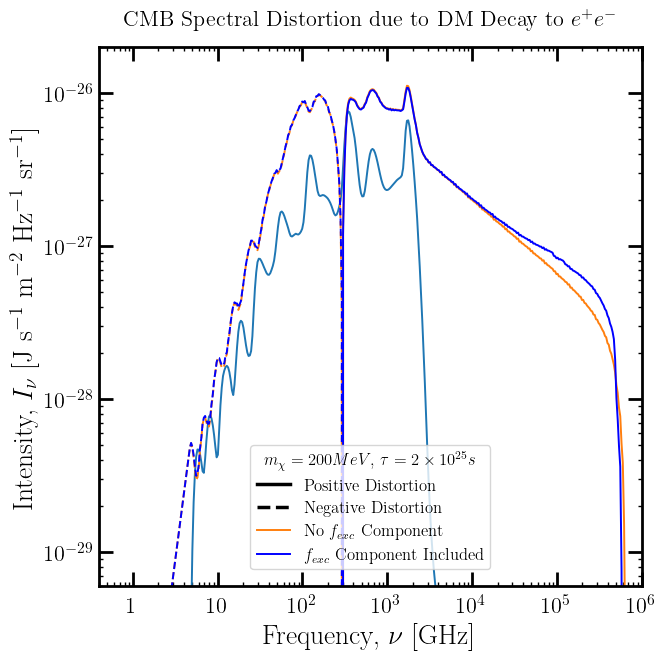

In [549]:
eng = baseline['distortion'].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
# rs_fac = 1300


plt.figure(figsize=(7, 7))
ax = plt.gca()

plot_distortion(ax, baseline, first=False)
plot_distortion(ax, DMrun, first=True, label=r'No $f_{exc}$ Component', leg=True)
plot_distortion(ax, DMrun_withf, color='blue', first=False,
                label=r'$f_{exc}$ Component Included')


# plt.xticks([1e1,1e2,1e3,1e4,1e5,1e6])

leg = plt.legend(fontsize=12)
leg.set_title(r'$m_\chi = 200 MeV$, $\tau = 2 \times 10^{25}s$')
plt.setp(leg.get_title(),fontsize='12')

plt.title('CMB Spectral Distortion due to DM Decay to $e^+e^-$', fontsize=16)

# 3. $f_{exc}$ as an ionization source

In [219]:
rs_vec = DM_run0['rs']

Tr_vec, Tm_vec  = phys.TCMB(rs_vec), phys.Tm_std(rs_vec)
# Tm_vec = Tr_vec.copy()

xe_vec, x1s_vec  = phys.xHII_std(rs_vec), phys.xHI_std(rs_vec)
nH_vec = phys.nH * rs_vec**3

tau_vec = atomic.tau_np_1s(2,rs_vec)
x2s_vec = atomic.x2s_steady_state(rs_vec, Tr_vec, Tm_vec, xe_vec, x1s_vec, tau_vec)
x2_vec  = 4*x2s_vec

Text(0, 0.5, 'Fractional Difference in Ionization Rate')

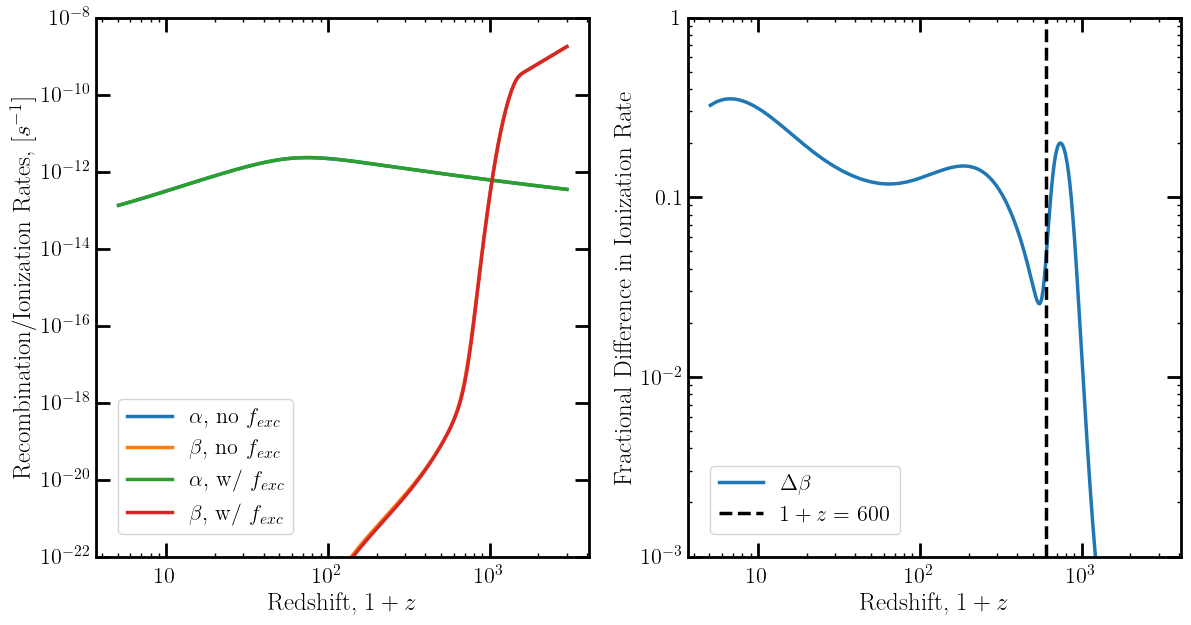

In [18]:
fig, axarr = plt.subplots(1,2, figsize=(14, 7))
axarr[0].loglog()
axarr[0].set_ylim([1e-22, 1e-8])

axarr[0].plot(DMrun_withf['rs'], DMrun_withf['MLA'][0][1:], label=r'$\alpha$, no $f_{exc}$')
axarr[0].plot(DMrun_withf['rs'], DMrun_withf['MLA'][1][1:], label=r'$\beta$, no $f_{exc}$')

axarr[0].plot(DMrun['rs'], DMrun['MLA'][0][1:], label=r'$\alpha$, w/ $f_{exc}$')
axarr[0].plot(DMrun['rs'], DMrun['MLA'][1][1:], label=r'$\beta$, w/ $f_{exc}$')

# axarr[0].plot(DM_run0['rs'], phys.alpha_recomb(Tm_vec, 'HI') + 0*xe_vec**2*nH_vec)
# rate = phys.beta_ion(Tr_vec, 'HI') * x2_vec
# axarr[0].plot(DM_run0['rs'], rate)

axarr[0].set_xlabel('Redshift, $1+z$')
axarr[0].set_ylabel('Recombination/Ionization Rates, [$s^{-1}$]')
axarr[0].legend()

# plt.plot(DM_run_withf0['rs'], np.abs(DM_run_withf0['MLA'][0][1:]/DM_run0['MLA'][0][1:]-1),
#          label=r'$\alpha$')


axarr[1].loglog()
axarr[1].set_ylim([1e-3, 1])
axarr[1].plot(DMrun_withf['rs'], DMrun_withf['MLA'][1][1:]/DMrun['MLA'][1][1:]-1,
         label=r'$\Delta \beta$')

axarr[1].axvline(600, linestyle='--', color='k', label=r'$1+z=600$')

axarr[1].legend()
axarr[1].set_xlabel('Redshift, $1+z$')
axarr[1].set_ylabel('Fractional Difference in Ionization Rate')

Text(0, 0.5, 'Fractional Difference in Ionization Rate')

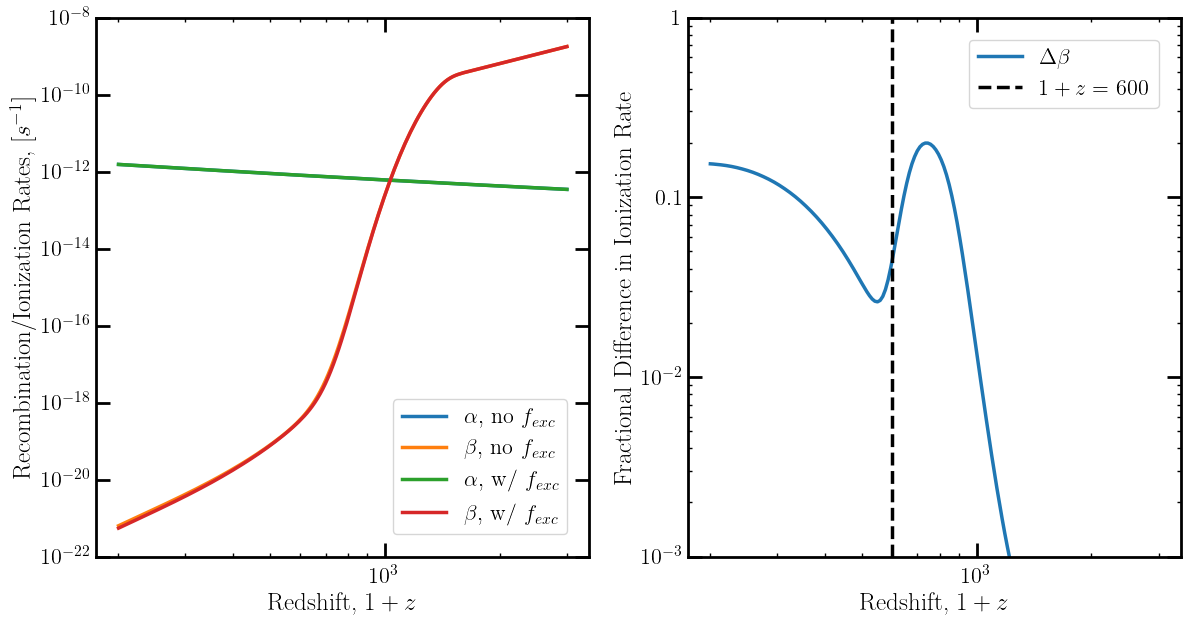

In [225]:
fig, axarr = plt.subplots(1,2, figsize=(14, 7))
axarr[0].loglog()
axarr[0].set_ylim([1e-22, 1e-8])

axarr[0].plot(DM_run_withf0['rs'], DMrun_withf['MLA'][0][1:], label=r'$\alpha$, no $f_{exc}$')
axarr[0].plot(DM_run_withf0['rs'], DMrun_withf['MLA'][1][1:], label=r'$\beta$, no $f_{exc}$')

axarr[0].plot(DM_run0['rs'], DMrun['MLA'][0][1:], label=r'$\alpha$, w/ $f_{exc}$')
axarr[0].plot(DM_run0['rs'], DMrun['MLA'][1][1:], label=r'$\beta$, w/ $f_{exc}$')

# axarr[0].plot(DM_run0['rs'], phys.alpha_recomb(Tm_vec, 'HI') + 0*xe_vec**2*nH_vec)
# rate = phys.beta_ion(Tr_vec, 'HI') * x2_vec
# axarr[0].plot(DM_run0['rs'], rate)

axarr[0].set_xlabel('Redshift, $1+z$')
axarr[0].set_ylabel('Recombination/Ionization Rates, [$s^{-1}$]')
axarr[0].legend()

# plt.plot(DM_run_withf0['rs'], np.abs(DM_run_withf0['MLA'][0][1:]/DM_run0['MLA'][0][1:]-1),
#          label=r'$\alpha$')


axarr[1].loglog()
axarr[1].set_ylim([1e-3, 1])
axarr[1].plot(DMrun_withf['rs'], DMrun_withf['MLA'][1][1:]/DMrun['MLA'][1][1:]-1,
         label=r'$\Delta \beta$')

axarr[1].axvline(600, linestyle='--', color='k', label=r'$1+z=600$')

axarr[1].legend()
axarr[1].set_xlabel('Redshift, $1+z$')
axarr[1].set_ylabel('Fractional Difference in Ionization Rate')

In [235]:
# import pickle
# MLA_data = pickle.load(open(
#     '/Users/gregoryridgway/Desktop/Data/'+
#     'MLA_rates_nmax100_nlogdlnz3.0_endrs200fudge1.125.dat', 'rb'
# ))

# MLA_funcs = np.array([
#     interp1d(DM_run_withf0['rs'], DM_run_withf0['MLA'][0][1:]),
#     interp1d(np.log(DM_run_withf0['rs']), np.log(DM_run_withf0['MLA'][1:]))
# ])

In [507]:
from darkhistory.history import tla

beta_func = interp1d(np.log(DMrun['rs']), np.log(DMrun['MLA'][1][1:]))
def beta_MLA(rs):
    return np.exp(beta_func(np.log(rs)))

MLA_funcs = np.array([
    interp1d(DMrun['rs'], DMrun['MLA'][0][1:]),
    beta_MLA
])

f_raw = {key: interp1d(DMrun['rs'], DMrun['f'][key],
                       bounds_error=False, fill_value = (0,0))
         for key in DMrun['f'].keys()}

def f_H_ion(rs, xHI, xHeI, xHeII):
    return f_raw['H ion'](rs)
def f_heat(rs, xHI, xHeI, xHeII):
    return f_raw['heat'](rs)
def f_H_exc(rs, xHI, xHeI, xHeII):
    return f_raw['Lya'](rs)

def rate_func_eng(rs):
    return phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=param, sigmav=param)

rs_vec = 10**(np.arange(np.log10(3e3),np.log10(5.4),-.001*16))

iterated = tla.get_history(
    rs_vec, high_rs=np.inf,
    f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
    injection_rate=rate_func_eng,
    recfast_TLA=False,
    alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
    mxstep=10000, rtol=1e-8
)

beta_func = interp1d(np.log(DMrun_withf['rs']), np.log(DMrun_withf['MLA'][1][1:]))
def beta_MLA(rs):
    return np.exp(beta_func(np.log(rs)))

MLA_funcs = np.array([
    interp1d(DMrun_withf['rs'], DMrun_withf['MLA'][0][1:]),
    beta_MLA
])

iterated_withf = tla.get_history(
    rs_vec, high_rs=np.inf,
    f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
    injection_rate=rate_func_eng,
    recfast_TLA=False,
    alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
    mxstep=10000, rtol=1e-8
)

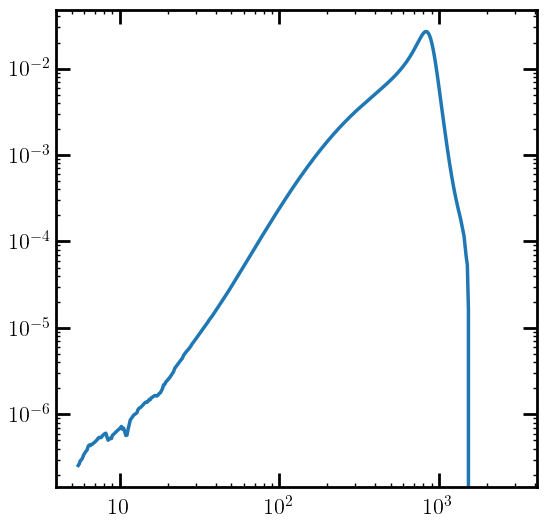

In [122]:
plt.figure()
plt.loglog()
# plt.plot(rs_vec, perturbed[:,1])
# plt.plot(rs_vec, perturbed0[:,1])

plt.plot(rs_vec, iterated_withf[:,1]/iterated[:,1]-1)
# plt.plot(rs_vec, iterated[:,1]/phys.xHII_std(rs_vec)-1)

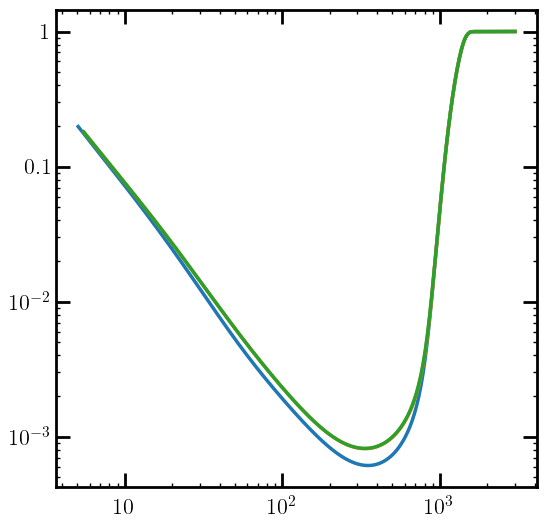

In [120]:
plt.figure()
plt.loglog()

plt.plot(DMrun['rs'], DMrun['x'][:,0])
# plt.plot(baseline['rs'], baseline['x'][:,0])
plt.plot(rs_vec, iterated[:,1])
plt.plot(rs_vec, iterated_withf[:,1])

# 4. $f_{ion}$ as a distortion source

In [198]:
%autoreload
DMrun_withf_nofion = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=True,
    fexc_switch = True, reprocess_distortion=False, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:442: RuntimeWarning: overflow encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:446: RuntimeWarning: overflow encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:442: RuntimeWarning: divide by zero encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:446: RuntimeWarning: divide by zero encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/D

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

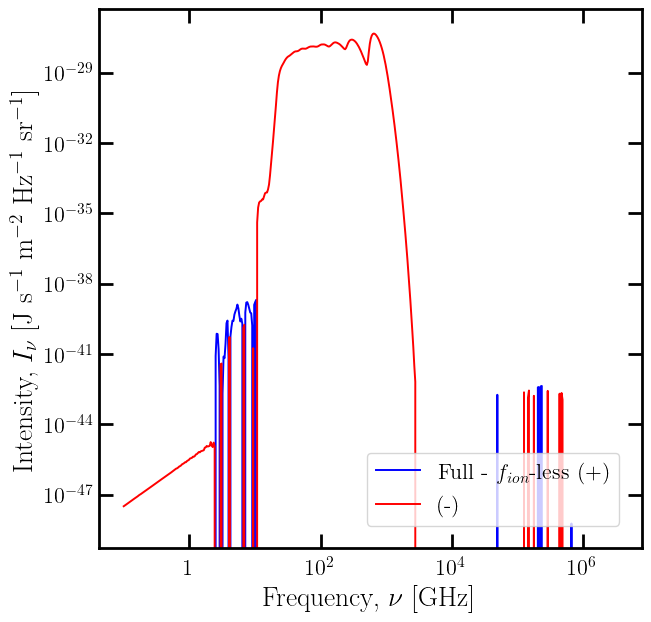

In [209]:
eng = baseline['distortion'].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
# rs_fac = 1300


plt.figure(figsize=(7, 7))
plt.loglog()
# plt.xlim([4e-1, 1e6])
# plt.ylim([6e-30, 2e-26])

# DH generated data
# plt.plot(nu/1e9, convert * baseline['distortion'].dNdE,
#          color='C0', linewidth=1.4, label='no DM')
# plt.plot(nu/1e9, convert * DM_run['distortion'].dNdE,
#          color='blue', linewidth=1.4,
#          label='w/ DM, no $f_{exc}$, (+)', linestyle='--', alpha=0.6)
# plt.plot(nu/1e9, -convert * DM_run['distortion'].dNdE,
#          color='red', linewidth=1.4,
#          label='(-)', linestyle='--', alpha=0.6)

# plt.plot(nu/1e9, convert * DM_run_withf['distortion'].dNdE,
#          color='blue', linewidth=1.4, label='w/ DM, w/ $f_{exc}$, (+)')
# plt.plot(nu/1e9, -convert * DM_run_withf['distortion'].dNdE,
#          color='red', linewidth=1.4)

plt.plot(nu/1e9, convert * (
    DM_run_withf['distortion'].dNdE - DM_run_withf_BF0['distortion'].dNdE),
         color='blue', linewidth=1.4, label='Full - $f_{ion}$-less (+)')
plt.plot(nu/1e9, -convert * (
    DM_run_withf['distortion'].dNdE - DM_run_withf_BF0['distortion'].dNdE),
         color='red', linewidth=1.4, label='(-)')

plt.legend(loc=4)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

# 4. Distortion ($\Delta f_\gamma$) as an ionization source

In [575]:
%%prun
main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param, sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=2.8e3,
    coarsen_factor=coarsen_factor, backreaction=True,
    distort=True, recfast_TLA=True,
    fexc_switch=True, reprocess_distortion=True, nmax=300
)

  0%|          | 0/5.0 [00:00<?, ?it/s]

In [1467]:
atomic.p_np_1s(np.arange(2,11), 100, xHI=1e-6)

array([0.0487103 , 0.29246136, 0.59567463, 0.77369783, 0.86525991,
       0.9143662 , 0.94249598, 0.95962023, 0.97059577])

In [1936]:
%autoreload

nmax = 2
start_rs, high_rs, end_rs = 1.8e3, 1.555e3, 900
cf = 16
rtol = 1e-6

rs_list = np.exp(np.arange(np.log(start_rs), np.log(end_rs), -.001*cf))
R = atomic.populate_radial(nmax)
Thetas = bf.populate_thetas(nmax)
dist_eng = np.exp(np.linspace(np.log(hplanck*1e8), np.log(phys.rydberg), 10))

pri = 'elec'
DM_process = 'decay'
mDM = 2e8
param = param_bound(mDM, DM_process, pri)*1e20

# Initialize the iterations by generating the rates
rates = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param, sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs=high_rs, end_rs=end_rs,
    coarsen_factor=cf,
    distort=True, recfast_TLA=True,
    nmax=nmax, rtol=rtol
)['MLA']
    
MLA_funcs = [interp1d(rates[0], rates[i], fill_value='extrapolate')
             for i in range(1,4)]

iterated_30 = {}
for i in np.arange(3):
    iterated_30[i] = main.evolve(
        DM_process=DM_process, mDM=mDM,
        lifetime=param, sigmav=param,
        primary=pri+'_delta',
        start_rs = start_rs, high_rs = high_rs, end_rs=end_rs,
        coarsen_factor=cf,
        distort=True, recfast_TLA=False, MLA_funcs=MLA_funcs,
        nmax=nmax, rtol=rtol
    )
    
    rates = iterated_30[i]['MLA']
    
    MLA_funcs = [interp1d(rates[0], rates[j],
                          fill_value='extrapolate')
             for j in range(1,4)]

# iterated_30[0] = {'rs': rs_list, 'x': out[:,1:3]}

  0%|          | 0/44.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:61: RuntimeWarning: invalid value encountered in power
  res = C * (w * (1 - 4**gam * w**gam) + alp * w**(bet + gam) * 4**gam)


  0%|          | 0/44.0 [00:00<?, ?it/s]

  0%|          | 0/44.0 [00:00<?, ?it/s]

  0%|          | 0/44.0 [00:00<?, ?it/s]

In [1892]:
#iterated_30_elec_decay_2e8 = iterated_30.copy()

In [1917]:
iterated_30[i]['x'][:,0]/iterated_30[i-1]['x'][:,0]-1

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -9.56149981e-05, -1.98678106e-04,
       -3.84477277e-04, -7.35526865e-04, -1.23206180e-03, -1.81621537e-03,
       -2.42293301e-03, -2.98890258e-03, -3.46488839e-03, -3.81922059e-03,
       -4.03783518e-03, -4.11973404e-03, -4.07568779e-03, -3.92330407e-03,
       -3.68341744e-03, -3.37877955e-03, -3.03174022e-03, -2.66257975e-03,
       -2.28942478e-03, -1.92734489e-03, -1.58766935e-03, -1.27821387e-03,
       -1.00420085e-03, -7.67973207e-04, -5.69418237e-04, -4.07069036e-04,
       -2.77841410e-04, -1.77969431e-04, -1.03417403e-04, -4.99535482e-05,
       -1.36040479e-05,  9.25921103e-06,  2.24010151e-05,  2.82660839e-05])

In [1918]:
iterated_30[i]['MLA'][1]/iterated_30[i-1]['MLA'][1]-1

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.71696546e-03,
       -4.46287052e-03, -5.02546241e-03, -5.72951351e-03, -5.92654408e-03,
       -5.60085645e-03, -4.96492229e-03, -4.20582778e-03, -3.44813285e-03,
       -2.75846100e-03, -2.16461536e-03, -1.67103886e-03, -1.27136616e-03,
       -9.54110518e-04, -7.06294846e-04, -5.15587708e-04, -3.70915843e-04,
       -2.62704063e-04, -1.82977047e-04, -1.25173101e-04, -8.39601180e-05,
       -5.50940350e-05, -3.52789205e-05, -2.19711838e-05, -1.32435379e-05,
       -7.67488305e-06, -4.23188279e-06, -2.17995946e-06, -1.01293526e-06,
       -3.88515267e-07, -8.32892556e-08,  4.41724630e-08,  8.20868566e-08,
        7.82916867e-08])

In [1919]:
iterated_30[i]['MLA'][2]/iterated_30[i-1]['MLA'][2]-1

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.71696549e-03,
       -4.46287056e-03, -5.02546283e-03, -5.72951394e-03, -5.92654489e-03,
       -5.60085776e-03, -4.96492523e-03, -4.20583036e-03, -3.44813641e-03,
       -2.75846533e-03, -2.16462067e-03, -1.67104476e-03, -1.27137303e-03,
       -9.54118278e-04, -7.06303359e-04, -5.15596867e-04, -3.70925704e-04,
       -2.62714323e-04, -1.82987590e-04, -1.25183925e-04, -8.39709107e-05,
       -5.51046681e-05, -3.52892790e-05, -2.19806087e-05, -1.32513681e-05,
       -7.68311451e-06, -4.23885566e-06, -2.18554972e-06, -1.01710729e-06,
       -3.91094012e-07, -8.41932787e-08,  4.49320869e-08,  8.44569674e-08,
        8.19540829e-08])

Text(0.5, 0, 'Redshift, $1+z$')

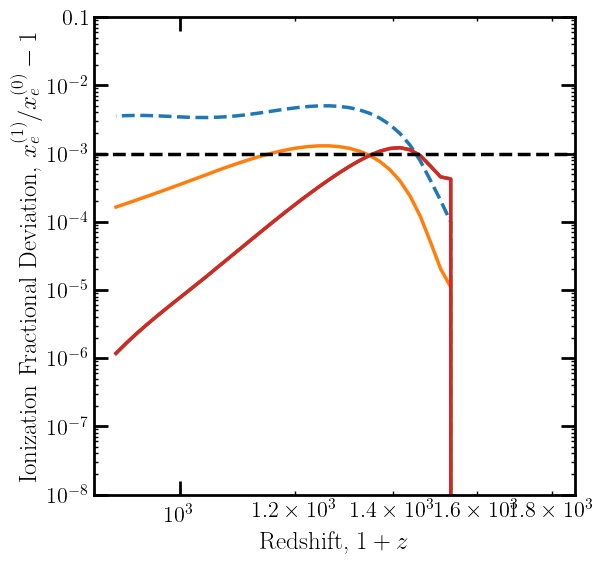

In [1937]:
plt.figure()
plt.loglog()

plt.ylim([1e-8,1e-1])

for i in np.arange(2):
    plt.plot(iterated_30[0]['rs'], iterated_30[i+1]['x'][:,0]/iterated_30[i]['x'][:,0]-1)
    plt.plot(iterated_30[0]['rs'], 1-iterated_30[i+1]['x'][:,0]/iterated_30[i]['x'][:,0],
             linestyle = '--', color='C'+str(i))
    
plt.plot(iterated_30[i+1]['MLA'][0], iterated_30[i+1]['MLA'][1]/iterated_30[i]['MLA'][1]-1)
plt.plot(iterated_30[i+1]['MLA'][0], iterated_30[i+1]['MLA'][2]/iterated_30[i]['MLA'][2]-1)


plt.axhline(1e-3, color='k', linestyle='--')
plt.ylabel(r'Ionization Fractional Deviation, $x_e^{(1)}/x_e^{(0)}-1$')
plt.xlabel(r'Redshift, $1+z$')

Text(0.5, 1.0, 'Lyman-$\\alpha$ Optical Depth')

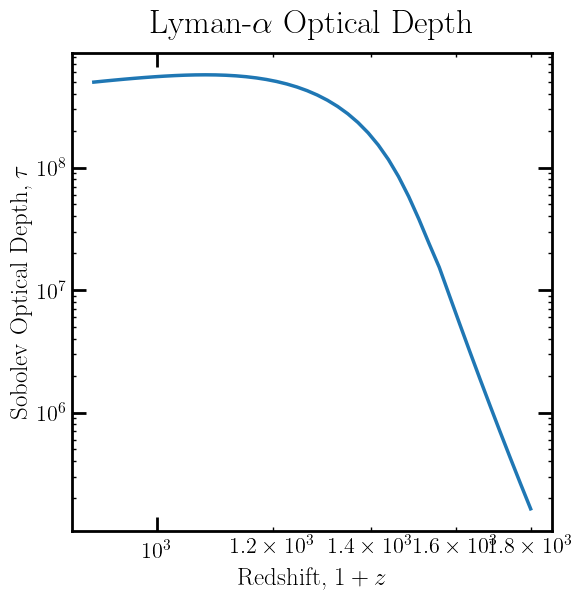

In [1951]:
plt.figure()
plt.loglog()
plt.plot(iterated_30[0]['rs'],
atomic.tau_np_1s(2, iterated_30[0]['rs'], 1-iterated_30[i+1]['x'][:,0])
        )

plt.ylabel(r'Sobolev Optical Depth, $\tau$')
plt.xlabel(r'Redshift, $1+z$')
plt.title(r'Lyman-$\alpha$ Optical Depth')

Text(0.5, 1.0, '2-state MLA, $n_{max}=2$')

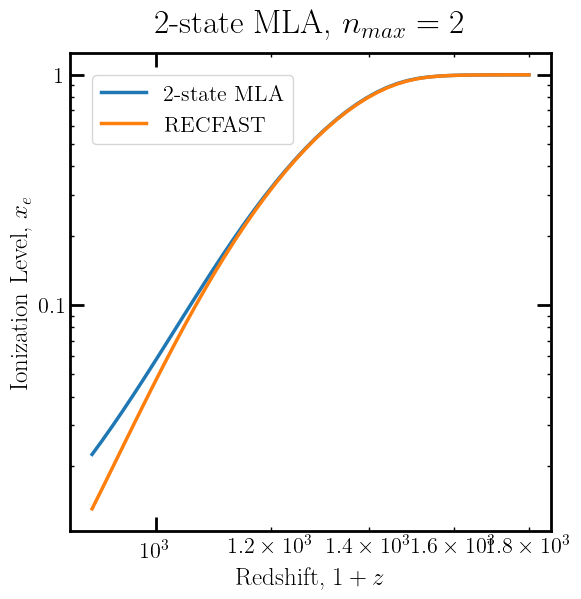

In [1942]:
plt.figure()
plt.loglog()

plt.plot(iterated_30[0]['rs'], iterated_30[i+1]['x'][:,0], label='2-state MLA')
plt.plot(iterated_30[0]['rs'], phys.x_std(iterated_30[0]['rs']), label='RECFAST')

plt.legend()

plt.ylabel(r'Ionization Level, $x_e$')
plt.xlabel(r'Redshift, $1+z$')
plt.title(r'2-state MLA, $n_{max}=2$')

Text(0.5, 0, 'Redshift, $1+z$')

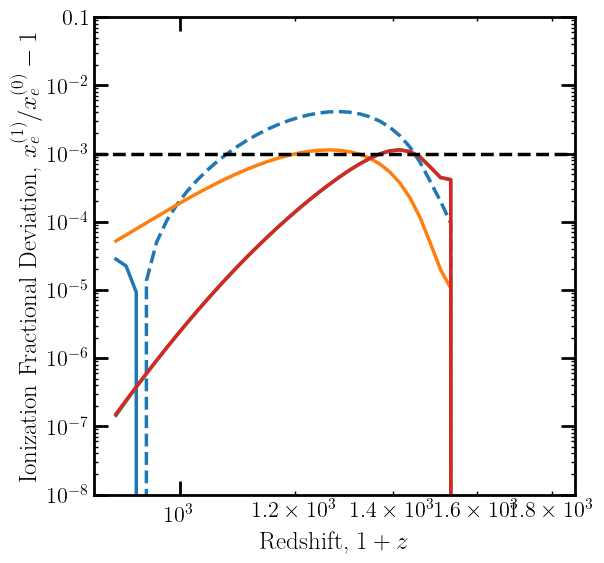

In [1914]:
plt.figure()
plt.loglog()

plt.ylim([1e-8,1e-1])

for i in np.arange(2):
    plt.plot(iterated_30[0]['rs'], iterated_30[i+1]['x'][:,0]/iterated_30[i]['x'][:,0]-1)
    plt.plot(iterated_30[0]['rs'], 1-iterated_30[i+1]['x'][:,0]/iterated_30[i]['x'][:,0],
             linestyle = '--', color='C'+str(i))
    
plt.plot(iterated_30[i+1]['MLA'][0], iterated_30[i+1]['MLA'][1]/iterated_30[i]['MLA'][1]-1)
plt.plot(iterated_30[i+1]['MLA'][0], iterated_30[i+1]['MLA'][2]/iterated_30[i]['MLA'][2]-1)


plt.axhline(1e-3, color='k', linestyle='--')
plt.ylabel(r'Ionization Fractional Deviation, $x_e^{(1)}/x_e^{(0)}-1$')
plt.xlabel(r'Redshift, $1+z$')

Text(0.5, 0, 'Redshift, $1+z$')

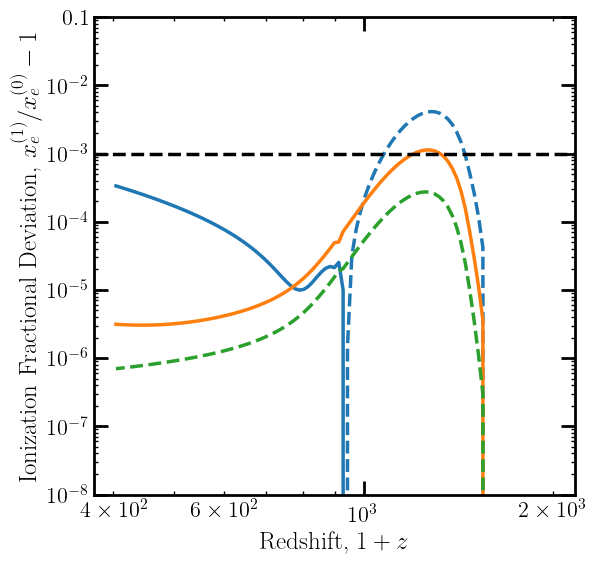

In [1895]:
plt.figure()
plt.loglog()

plt.ylim([1e-8,1e-1])

for i in np.arange(3):
    plt.plot(iterated_30[0]['rs'], iterated_30[i+1]['x'][:,0]/iterated_30[i]['x'][:,0]-1)
    plt.plot(iterated_30[0]['rs'], 1-iterated_30[i+1]['x'][:,0]/iterated_30[i]['x'][:,0],
             linestyle = '--', color='C'+str(i))

plt.axhline(1e-3, color='k', linestyle='--')
plt.ylabel(r'Ionization Fractional Deviation, $x_e^{(1)}/x_e^{(0)}-1$')
plt.xlabel(r'Redshift, $1+z$')

Text(0.5, 0, 'Redshift, $1+z$')

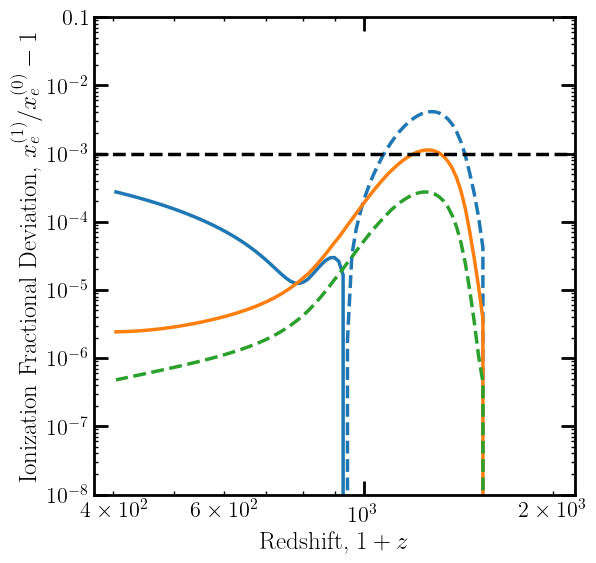

In [1891]:
plt.figure()
plt.loglog()

plt.ylim([1e-8,1e-1])

for i in np.arange(3):
    plt.plot(iterated_30[0]['rs'], iterated_30[i+1]['x'][:,0]/iterated_30[i]['x'][:,0]-1)
    plt.plot(iterated_30[0]['rs'], 1-iterated_30[i+1]['x'][:,0]/iterated_30[i]['x'][:,0],
             linestyle = '--', color='C'+str(i))

plt.axhline(1e-3, color='k', linestyle='--')
plt.ylabel(r'Ionization Fractional Deviation, $x_e^{(1)}/x_e^{(0)}-1$')
plt.xlabel(r'Redshift, $1+z$')

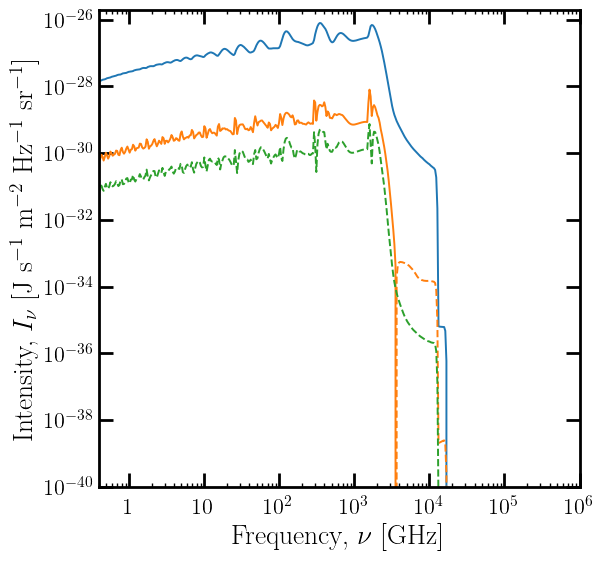

In [1663]:
plt.figure()
ax = plt.gca()
plot_distortion(ax, iterated[1])
plot_distortion(ax, iterated[1], iterated[2], diff=True, ylim=[1e-40,2e-26])
plot_distortion(ax, iterated[2], iterated[3], diff=True, ylim=[1e-40,2e-26])
# plot_distortion(ax, iterated[1], iterated['alt'], diff=True, ylim=[1e-40,2e-26])
# plt.plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
#          linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)

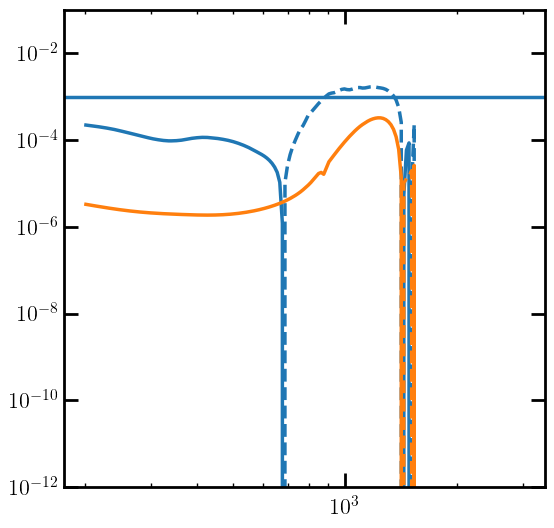

In [762]:
plt.figure()
plt.loglog()
# plt.plot(iterated[0]['rs'], iterated[0]['x'][:,0])
# plt.plot(iterated[1]['rs'], iterated[1]['x'][:,0])

# plt.plot(iterated[0]['rs'], iterated[0]['x'][:,0])

plt.ylim([1e-12,1e-1])
# terp = interp1d(iterated[0]['rs'], iterated[0]['x'][:,0], fill_value='extrapolate')
# plt.plot(iterated[1]['rs'], iterated[1]['x'][:,0]/terp(iterated[1]['rs'])-1)
# plt.plot(iterated[1]['rs'], 1-iterated[1]['x'][:,0]/terp(iterated[1]['rs']),
#          linestyle = '--', color='C0')

plt.plot(iterated[1]['rs'], iterated[2]['x'][:,0]/iterated[1]['x'][:,0]-1)
plt.plot(iterated[1]['rs'], 1-iterated[2]['x'][:,0]/iterated[1]['x'][:,0],
         linestyle = '--', color='C0')

plt.plot(iterated[1]['rs'], iterated[3]['x'][:,0]/iterated[2]['x'][:,0]-1)
plt.plot(iterated[1]['rs'], 1-iterated[3]['x'][:,0]/iterated[2]['x'][:,0],
         linestyle = '--', color='C1')

plt.axhline(1e-3)

In [2037]:
%autoreload
tmp = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param, sigmav=param,
    primary=pri+'_delta',
    start_rs = 25, high_rs = 1.555e3, end_rs=19,
    coarsen_factor=cf, backreaction=True,
    distort=True, recfast_TLA=True,
    fexc_switch=True, reprocess_distortion=True, nmax=10
)

  0%|          | 0/18.0 [00:00<?, ?it/s]

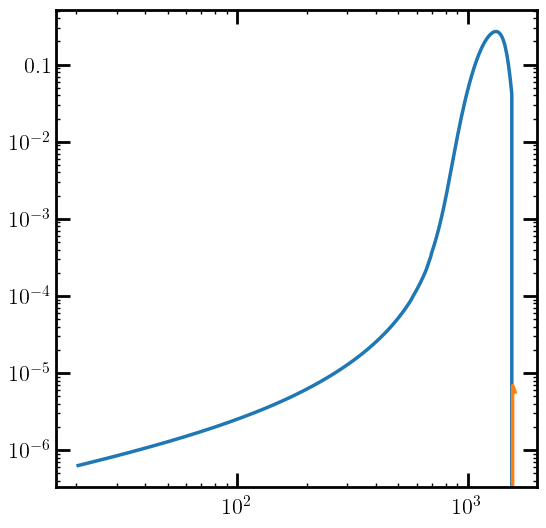

In [2004]:
plt.figure()
ax = plt.gca()
ax.loglog()
# plot_distortion(ax, DM_run_withf_withDf)
ax.plot(tmp['rs'], tmp['distortions'].toteng())
ax.plot(tmp['rs'], -tmp['distortions'].toteng())

In [137]:
MLA_funcs = np.array([
    interp1d(DM_run_withf_withDf['rs'], DM_run_withf_withDf['MLA'][0][1:]),
    interp1d(np.log(DM_run_withf_withDf['rs']), np.log(DM_run_withf_withDf['MLA'][1][1:]))
])

iterated_withf_withDf = tla.get_history(
    rs_vec, high_rs=np.inf,
    f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
    injection_rate=rate_func_eng,
    recfast_TLA=False,
    alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
    mxstep=10000, rtol=1e-8
)

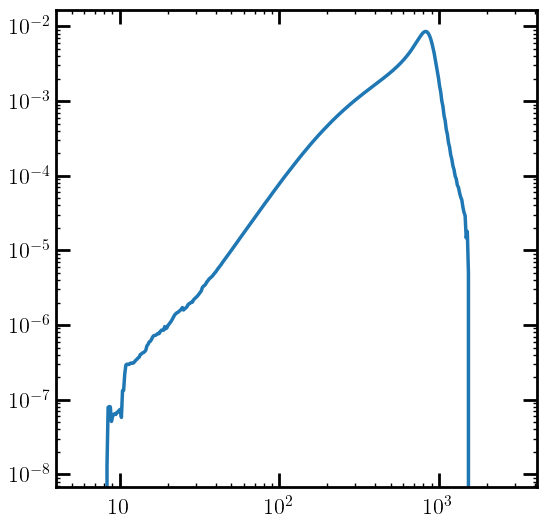

In [141]:
plt.figure()
plt.loglog()
# plt.plot(rs_vec, perturbed[:,1])
# plt.plot(rs_vec, perturbed0[:,1])

# plt.plot(rs_vec, iterated_withf[:,1]/iterated[:,1]-1)
plt.plot(rs_vec, iterated_withf_withDf[:,1]/iterated_withf[:,1]-1)
# plt.plot(rs_vec, iterated_withf_withDf[:,1]/iterated[:,1]-1)
# plt.plot(rs_vec, iterated[:,1]/phys.xHII_std(rs_vec)-1)

# 5. Reprocessing of distortion ($\Delta f_\gamma \to $ distortion)

Text(0.5, 1.0, 'CMB Spectral Distortion due to DM Decay to $e^+e^-$')

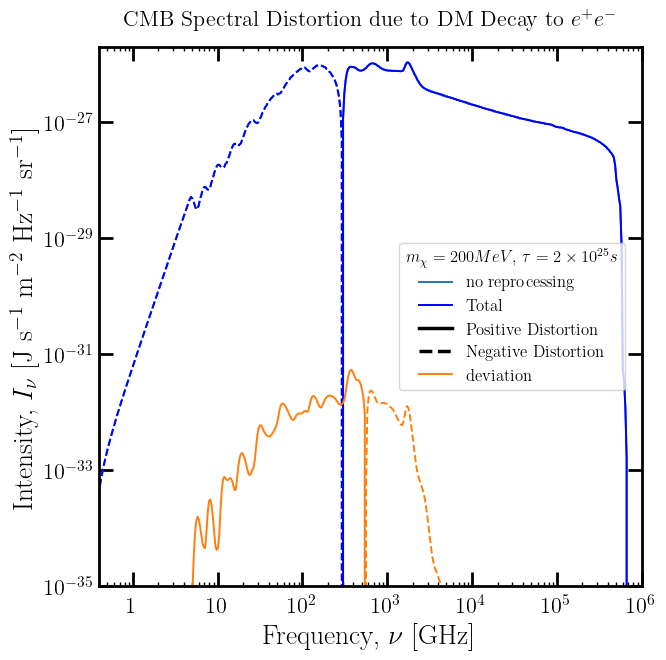

In [561]:
plt.figure(figsize=(7, 7))
ax = plt.gca()

# DH generated data
# plt.plot(tmp.eng/hplanck/1e9, phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
#          color='C1', linewidth=1.4, label='pure ICS', alpha=0.7)
# plt.plot(tmp.eng/hplanck/1e9, -phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
#          color='C1', linestyle='--', linewidth=1.4, alpha=0.7)

plot_distortion(ax, DMrun_withf, label='no reprocessing',
                first=False, leg=True)
plot_distortion(ax, DM_run_withf_withDf, color='blue', label='Total',
                first=False, leg=True)

plot_distortion(ax, DM_run_withf_withDf, DMrun_withf, 
                label='deviation', leg=True, diff=True,
                color='C1', ylim=[1e-35,2e-26])


leg = plt.legend(fontsize=12)
leg.set_title(r'$m_\chi = 200 MeV$, $\tau = 2 \times 10^{25}s$')
plt.setp(leg.get_title(),fontsize='12')

plt.title('CMB Spectral Distortion due to DM Decay to $e^+e^-$', fontsize=16)

# Iteration

In [ ]:
n_iter = 5

f_iterations = {}
f_iterations[0] = DMrun_withf

for i in np.arange(1,n_iter):
    
    iterations[i] = main.iterate(
        iterations[i-1],
        pri, DM_process, mDM, param,
        start_rs, end_rs, coarsen_factor,
        nmax, recfast_TLA=True
    )

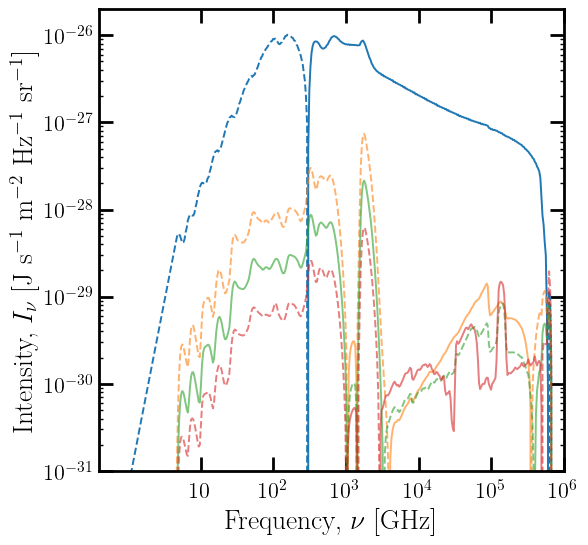

In [625]:
plt.figure(figsize=(6,6))
ax = plt.gca()

plot_distortion(ax, f_iterations[n_iter-1])
for i in np.arange(n_iter-1):
    plot_distortion(
        ax, f_iterations[i+1], f_iterations[i],
        diff=True, ylim=[1e-31, 2e-26], alpha=0.6
    )

In [785]:
rs_vec = DMrun_withf['rs']
MLA_data = DMrun_withf['MLA']
alpha_MLA = interp1d(rs_vec, MLA_data[0][1:],
                     bounds_error=False, fill_value='extrapolate')
beta_func = interp1d(np.log(rs_vec), np.log(MLA_data[1][1:]),
                     bounds_error=False, fill_value='extrapolate')
def beta_MLA(rs):
    return np.exp(beta_func(np.log(rs)))
MLA_funcs = [alpha_MLA, beta_MLA]

# to establish a baseline
DMrun_x_iter0 = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=5,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=False, MLA_funcs = MLA_funcs,
    fexc_switch = True, reprocess_distortion=False, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:477: RuntimeWarning: overflow encountered in true_divide
  
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:481: RuntimeWarning: overflow encountered in double_scalars
  # Special 2s->1s transition
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:477: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:481: RuntimeWarning: divide by zero encountered in double_scalars
  # Special 2s->1s transition
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:508: RuntimeWarning: invalid value encountered in double_s

In [744]:
%autoreload

iterations[6] = main.iterate(
    iterations[5],
    pri, DM_process, mDM, param,
    start_rs, end_rs, coarsen_factor,
    nmax
)

  0%|          | 0/400 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


  0%|          | 0/400.0 [00:00<?, ?it/s]

In [783]:
iterations_OLD = iterations.copy()

In [786]:
n_iter = 10

iterations = {}
iterations[0] = DMrun_x_iter0

for i in np.arange(1,n_iter):
    
    iterations[i] = main.iterate(
        iterations[i-1],
        pri, DM_process, mDM, param,
        start_rs, end_rs, coarsen_factor,
        nmax
    )

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../main.py:1395: RuntimeWarning: invalid value encountered in log
  beta_func = interp1d(np.log(rs_vec), np.log(MLA_data[1][1:]),


  0%|          | 0/400.0 [00:00<?, ?it/s]

42.536714247037445 [           nan            nan 5.43939893e-14 0.00000000e+00]


ValueError: Encountered nan in Tm or x

In [805]:
pri = 'elec'
rs_vec = DMrun_withf['rs']
MLA_data = DMrun_withf['MLA']
alpha_MLA = interp1d(rs_vec, MLA_data[0][1:],
                     bounds_error=False, fill_value='extrapolate')
beta_func = interp1d(np.log(rs_vec), np.log(MLA_data[1][1:]),
                     bounds_error=False, fill_value='extrapolate')
def beta_MLA(rs):
    return np.exp(beta_func(np.log(rs)))
MLA_funcs = [alpha_MLA, beta_MLA]

# to establish a baseline
DMrun_x_iter0 = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=5,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=False, MLA_funcs = MLA_funcs,
    fexc_switch = True, reprocess_distortion=True, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


In [807]:
%autoreload
n_iter = 10

repro = {}
repro[0] = DMrun_x_iter0

for i in np.arange(1,n_iter):
    
    repro[i] = main.iterate(
        repro[i-1],
        pri, DM_process, mDM, param,
        start_rs, end_rs, coarsen_factor,
        nmax
    )

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

In [692]:
%autoreload
rs_vec = DMrun_withf['rs']
MLA_data = DMrun_withf['MLA']
alpha_MLA = interp1d(rs_vec, MLA_data[0][1:],
                     bounds_error=False, fill_value='extrapolate')
beta_func = interp1d(np.log(rs_vec), np.log(MLA_data[1][1:]),
                     bounds_error=False, fill_value='extrapolate')
def beta_MLA(rs):
    return np.exp(beta_func(np.log(rs)))
MLA_funcs = [alpha_MLA, beta_MLA]

DMrun_full = main.evolve(  #
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf,
    distort=True, recfast_TLA=False,
    fexc_switch = True, reprocess_distortion=True, nmax=nmax
#     Delta_f_2D = Delta_f_2D_iter2  #
)

  0%|          | 0/6397.0 [00:00<?, ?it/s]

[0. 0. 0.]


/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


[7.36456281e-18 7.26990750e-22 9.69683982e-19]
[ 1.45686246e-17 -7.68822102e-15  2.12998604e-18]
[ 1.90783482e-17 -1.36568744e-14  3.00618868e-18]
[ 1.81467892e-17 -1.90409317e-14  3.10590673e-18]
[ 2.19516846e-17 -2.39987116e-14  3.62156895e-18]
[ 2.66934136e-17 -2.86199552e-14  4.30359113e-18]
[ 2.29427899e-17 -3.29597381e-14  3.92402532e-18]
[ 2.31489611e-17 -3.70548366e-14  3.80760903e-18]
[ 2.65831178e-17 -4.09316377e-14  4.12367038e-18]
[ 2.75805683e-17 -4.46102791e-14  4.22626765e-18]
[ 2.87656326e-17 -4.81069116e-14  4.31783240e-18]
[ 3.18405122e-17 -5.14349615e-14  4.63535742e-18]
[ 3.75954838e-17 -5.46059715e-14  5.33262308e-18]
[ 3.44104459e-17 -5.76301405e-14  4.98897860e-18]
[ 3.38684061e-17 -6.05166089e-14  4.75345194e-18]
[ 3.16418647e-17 -6.32737087e-14  4.28636460e-18]
[ 2.70901978e-17 -6.59091290e-14  3.44756501e-18]
[ 2.75875845e-17 -6.84299388e-14  3.09209937e-18]
[ 2.89711351e-17 -7.08427018e-14  2.98593189e-18]
[ 2.82519328e-17 -7.31535799e-14  2.73841624e-18]
[ 2

KeyboardInterrupt: 

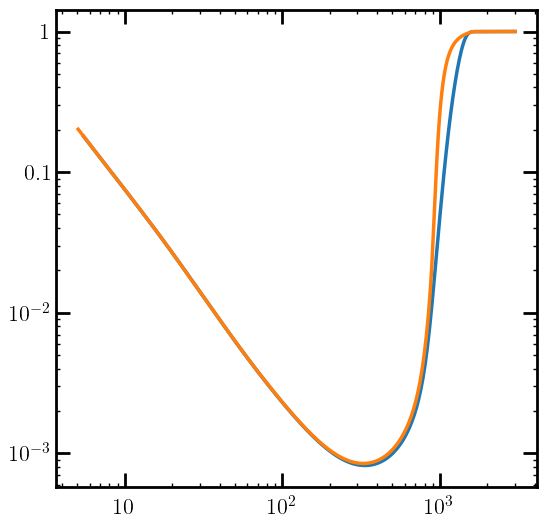

In [691]:
plt.figure()
plt.loglog()

plt.plot(iterations[0]['rs'], iterations[0]['x'][:,0])
plt.plot(DMrun_full['rs'], DMrun_full['x'][:,0])

(200, 2000.0)

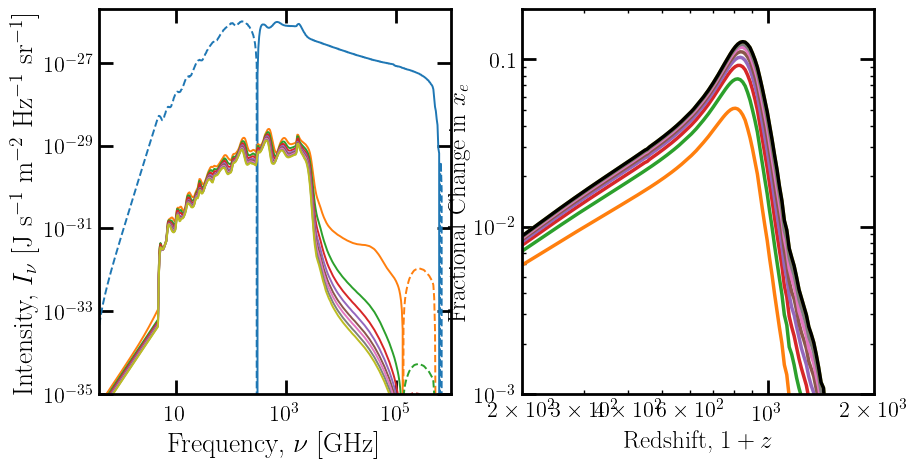

In [1152]:
f, axarr = plt.subplots(1,2, figsize=(10, 5))
n_iter=9

plot_distortion(axarr[0], repro[0])
for i in np.arange(n_iter-1):
    plot_distortion(
        axarr[0], repro[i+1], repro[i], diff=True, ylim=[1e-35, 2e-26]
    )
    

axarr[1].loglog()
for i in np.arange(n_iter-1):
    axarr[1].plot(repro[i+1]['rs'][:], 
                  np.abs(repro[i+1]['x'][:,0]/repro[0]['x'][:,0]-1),
                  color='C'+str(i+1))
    
axarr[1].plot(repro[n_iter-1]['rs'][:], 
                  np.abs(repro[n_iter-1]['x'][:,0]/repro[0]['x'][:,0]-1),
              color='k')

axarr[1].set_xlabel('Redshift, $1+z$')
axarr[1].set_ylabel('Fractional Change in $x_e$')
axarr[1].set_ylim([1e-3,.2])
axarr[1].set_xlim([200,2e3])

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


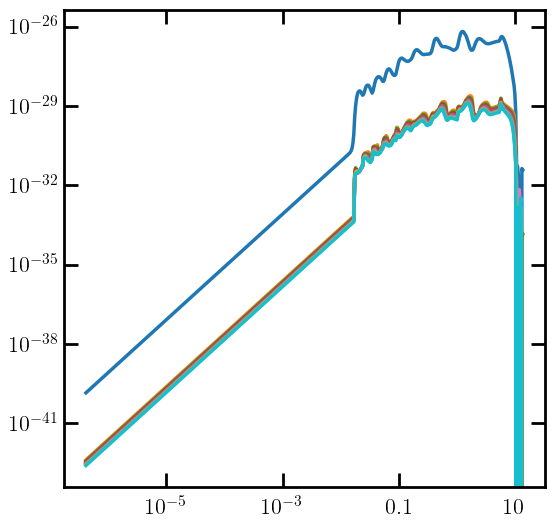

In [1155]:
plt.figure()
plt.loglog()

run = repro[0]

rs_list = run['rs']
rs_eval = 850

eng = run['distortion'].eng
hplanck = phys.hbar * 2*np.pi
nu = eng/hplanck
convert = phys.nB * eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4
    
run = repro[0]

specs = {}
for i,r in enumerate(repro):
    dists = repro[i]['distortions'].copy()
    dists.redshift(rs_eval)
    specs[i] = dists.sum_specs(rs_list > rs_eval)
    
    
plt.plot(eng, convert * (specs[0].dNdE))
for i in np.arange(len(repro)-1):
#     plt.plot(eng, convert * (specs[i].dNdE))
    plt.plot(eng, convert * (specs[i+1].dNdE-specs[i].dNdE))
#     plt.plot(eng, specs[i+1].dNdE/specs[i].dNdE - 1)

# plt.plot(eng, convert * (spec1.dNdE-spec0.dNdE))
# plt.plot(eng, -convert * (spec1.dNdE-spec0.dNdE), color='C'+str(i), linestyle='--')

In [452]:
%autoreload

pri = 'elec'
DM_process = 'decay'
mDM = 2e8
# mDM = 10**log10eng[::10][1] + phys.me
# mDM = 10**6.5
nmax=100

param = param_bound(mDM, DM_process, pri)
coarsen_factor = 16
string = str(int(np.floor(np.log10(mDM))))
start_rs = 1.6e3
end_rs = 1.55e3
high_rs = 1.555e3

reprocess_distortion=True
fexc_switch=False

# x_debug_fixed_x = {}  # set x = x_std, Delta_f=0, Tm=TCMB for rate calculations
x_dict = {}  # don't, but also don't absorb line photons

In [468]:
%%prun
%autoreload
x_dict[-1] = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param*1e20,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = high_rs, end_rs=end_rs,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=True,
    reprocess_distortion=reprocess_distortion,
    fexc_switch = fexc_switch, nmax=nmax,
    rtol=1e-8
)

  0%|          | 0/2.0 [00:00<?, ?it/s]

In [146]:
%autoreload

for i in np.arange(0,1):
    x_dict[i] = main.iterate(
        x_dict[i-1],
        pri, DM_process, mDM, param*1e20,
        start_rs, end_rs, coarsen_factor,
        nmax, reprocess_distortion=True,
        fexc_switch=fexc_switch, high_rs=high_rs,
        rtol=1e-8
    )

  0%|          | 0/18.0 [00:00<?, ?it/s]

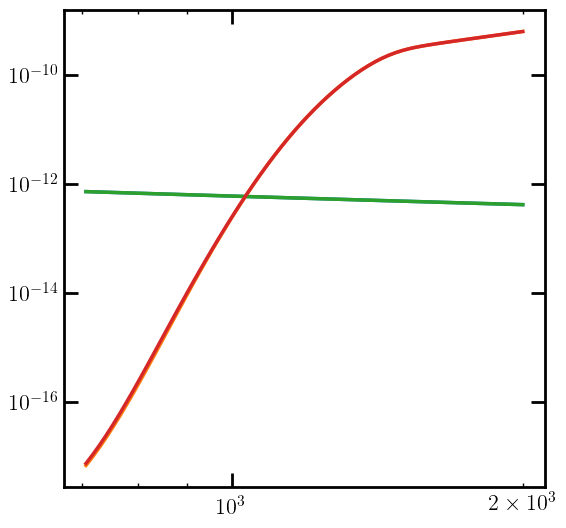

In [1441]:
plt.figure()
plt.loglog()

plt.plot(x_dict[0]['rs'], x_dict[0]['MLA'][0][1:])
plt.plot(x_dict[0]['rs'], x_dict[0]['MLA'][1][1:])

plt.plot(x_dict[3]['rs'], x_dict[3]['MLA'][0][1:])
plt.plot(x_dict[3]['rs'], x_dict[3]['MLA'][1][1:])

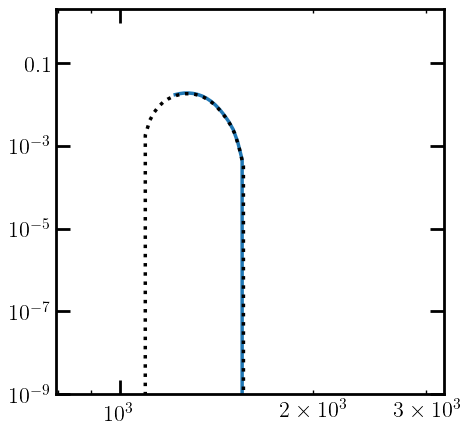

In [166]:
plt.figure(figsize=(5,5))
plt.loglog()
plt.ylim([1e-9,2])

def gauss_corr(rs):
    gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
    gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)

    return 1/(1 + gauss_corr_1 + gauss_corr_2)

k=0
model='phot_swave'

for i in np.arange(0,1):
    
    plt.plot(x_dict[i-1]['rs'], 
             (x_dict[i]['x'][:,0]-x_dict[i-1]['x'][:,0])/x_dict[0]['x'][:,0],
             label='xe '+str(i), color='C'+str(i))
    
    plt.plot(x_dict[i-1]['rs'], 
             -(x_dict[i]['x'][:,0]-x_dict[i-1]['x'][:,0])/x_dict[0]['x'][:,0],
             label='xe '+str(i), linestyle=':', color='C'+str(i))
    
plt.plot(rs_vec[:80], iter1[model][1][k]['x'][:80,0]/iter0[model][1][k]['x'][:80,0]-1, 'k:')
    
#     plt.plot(x_dict[i-1]['rs'], 0.079*np.exp(-((np.log(x_dict[i-1]['rs']) - 6.73)/0.33)**2))
    
#     plt.plot(x_dict[i-1]['rs'], 
#              x_dict[i]['x'][:,0],
#              label='xe '+str(i), color='C'+str(i))
    
#     plt.plot(x_dict[i-1]['rs'], 
#              x_dict[i-1]['x'][:,0],
#              label='xe '+str(i), linestyle=':', color='C'+str(i))

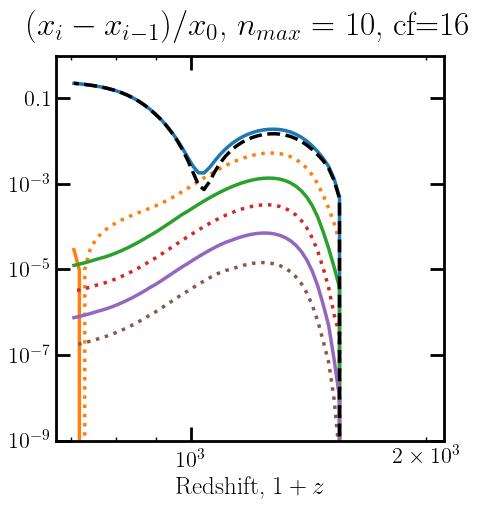

In [1651]:
plt.figure(figsize=(5,5))
plt.loglog()
plt.ylim([1e-9,1])

for i in np.arange(0,1):
    plt.plot(x_dict[i-1]['rs'], 
             (x_dict[i]['x'][:,0]-x_dict[i-1]['x'][:,0])/x_dict[0]['x'][:,0],
             label='xe '+str(i), color='C'+str(i))
    
    plt.plot(x_dict[i-1]['rs'], 
             -(x_dict[i]['x'][:,0]-x_dict[i-1]['x'][:,0])/x_dict[0]['x'][:,0],
             label='xe '+str(i), linestyle=':', color='C'+str(i))
    
#     plt.plot(x_dict[i-1]['rs'], 
#          (np.abs((x_dict[i]['MLA'][0]-x_dict[i-1]['MLA'][0]))/x_dict[0]['MLA'][0])[1:],
#          label=r'$\alpha$ '+str(i))
    
#     plt.plot(x_dict[i-1]['rs'], 
#          ((x_dict[i]['MLA'][1]-x_dict[i-1]['MLA'][1])/x_dict[0]['MLA'][1])[1:],
#          label=r'(+)$\beta$ '+str(i))
    
#     plt.plot(x_dict[i-1]['rs'], 
#          (-(x_dict[i]['MLA'][1]-x_dict[i-1]['MLA'][1])/x_dict[0]['MLA'][1])[1:],
#          label=r'(-)$\beta$ '+str(i), linestyle=':')
    
# plt.legend()
plt.title('$(x_i - x_{i-1})/x_0$, $n_{max}=10$, cf=16')
plt.xlabel('Redshift, $1+z$')


# tmp = x_dict[-1]['x'][:,0]
# for i in np.arange(6):
#     tmp += x_dict[i]['x'][:,0]

plt.plot(x_dict[5]['rs'], (x_dict[5]['x'][:,0]-x_dict[-1]['x'][:,0])/x_dict[0]['x'][:,0], 'k--')

# plt.plot(x_dict[i-1]['rs'], 
#              (x_dict[i]['x'][:,0]-x_dict[i-1]['x'][:,0])/x_dict[0]['x'][:,0],
#              label='xe '+str(i), color='C'+str(i))

#     plt.plot(x_dict[i-1]['rs'], np.abs(x_dict[i]['MLA'][1]/x_dict[i-1]['MLA'][1]-1)[1:],
#             linestyle='solid')
#     plt.plot(x_dict[i-1]['rs'], np.abs(x_dict[i]['MLA'][0]/x_dict[i-1]['MLA'][0]-1)[1:],
#             linestyle='--')

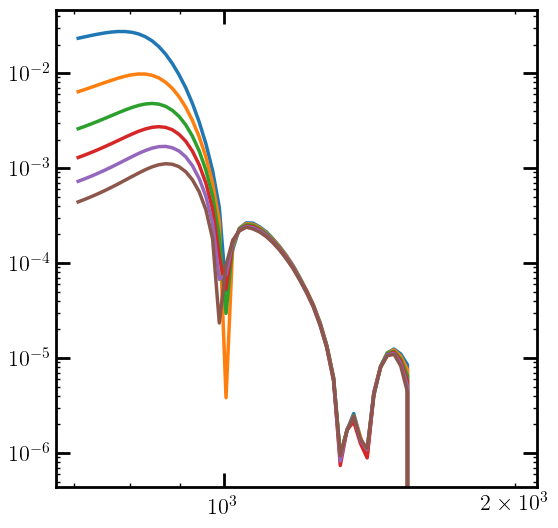

In [1331]:
plt.figure()
plt.loglog()

for i in np.arange(1,3):
    plt.plot(x_dict[i-1]['rs'], np.abs(x_dict[i]['x'][:,0]/x_dict[i-1]['x'][:,0]-1))
# plt.plot(x_debug[0]['rs'], np.abs(x_debug[1]['Tm']/x_debug[0]['Tm']-1))
# plt.plot(x_debug[0]['rs'], np.abs(np.abs(phys.Tm_std(x_debug[0]['rs'])/phys.TCMB(x_debug[0]['rs'])-1)))

In [ ]:
input_dir = '/Users/gregoryridgway/Desktop/Webplot Digitizer/Yacine_xe/'
yacine_xe = download_plot('Yacine_xe', input_dir)
yacine_diffs = {i : download_plot(str(i), input_dir) for i in [64, 128, 250, 500]}

## ???

In [243]:
%autoreload
DM_run_withf_withDf = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor, backreaction=True,
    cross_check=False, distort=True, recfast_TLA=True,
    fexc_switch = True, reprocess_distortion=True, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:466: RuntimeWarning: overflow encountered in true_divide
  b[nl] += xHI*BB['dn'][2][1][0]*np.exp(-phys.lya_eng/Tr)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:470: RuntimeWarning: overflow encountered in double_scalars
  spec_ind = str(n) + num_to_l(l)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/exam

In [295]:
rs_cut = 5

tmp = DM_run_withf_withDf2['distortions'].copy()
tmp.redshift(1.)

mask = np.ones_like(tmp.rs)
mask[DM_run_withf_withDf2['distortions'].rs < rs_cut] = 0

tmp = tmp.sum_specs(mask)

tmp2 = DM_run_withf['distortions'].copy()
tmp2.redshift(1.)

mask = np.ones_like(tmp2.rs)
mask[DM_run_withf['distortions'].rs < rs_cut] = 0

tmp2 = tmp2.sum_specs(mask)

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

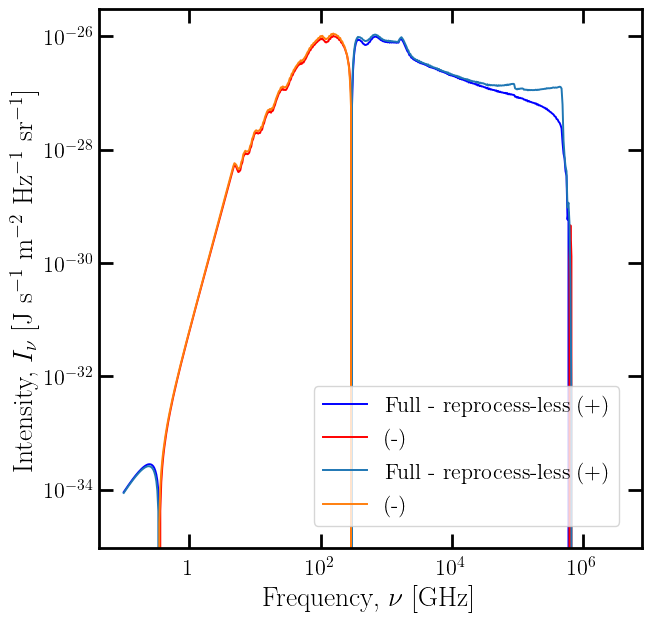

In [297]:
eng = baseline['distortion'].eng

plt.figure(figsize=(7, 7))
plt.loglog()

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

# plt.plot(nu/1e9, convert * (
#     DM_run_withf_withDf2['distortion'].dNdE - DM_run_withf_withDf['distortion'].dNdE),
#          color='blue', linewidth=1.4, label='Full - reprocess-less (+)')
# plt.plot(nu/1e9, -convert * (
#     DM_run_withf_withDf2['distortion'].dNdE - DM_run_withf_withDf['distortion'].dNdE),
#          color='red', linewidth=1.4, label='(-)')

plt.plot(nu/1e9, convert * tmp.dNdE,
         color='blue', linewidth=1.4, label='Full - reprocess-less (+)')
plt.plot(nu/1e9, -convert * tmp.dNdE,
         color='red', linewidth=1.4, label='(-)')

plt.plot(nu/1e9, convert * tmp2.dNdE,
         color='C0', linewidth=1.4, label='Full - reprocess-less (+)')
plt.plot(nu/1e9, -convert * tmp2.dNdE,
         color='C1', linewidth=1.4, label='(-)')

plt.legend(loc=4)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

# Scans

In [1983]:
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297

models = ['elec_decay', 'elec_swave', 'phot_decay', 'phot_swave']
data = {model : [] for model in models}

for pri in ['elec', 'phot'][:1]:
    for DM_process in ['decay', 'swave'][:1]:
        
        model = pri+'_'+DM_process
        print('starting', model)
        
        if pri=='elec':
            if DM_process=='decay':
                mDM_list = 2*(10**log10eng + phys.me)
            else:
                mDM_list = 10**log10eng + phys.me

        elif pri=='phot':
            if DM_process=='decay':
                mDM_list = 2*10**log10eng
            else:
                mDM_list = 10**log10eng
        
        for mDM in tqdm(mDM_list[:1]):
            
            param = param_bound(mDM, DM_process, pri)

            goods = main.evolve(
                DM_process=DM_process, mDM=mDM,
                lifetime=param,
                sigmav = param,
                primary=pri+'_delta',
                start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
                coarsen_factor=cf, backreaction=True,
                distort=True, recfast_TLA=True,
                fexc_switch=True, reprocess_distortion=True, nmax=nmax
            )
            
            data[model].append(goods)
            
# pickle.dump(data, open('/Users/gregoryridgway/Desktop/Data/'+
#                        'scan_nmax10_every10th.dat','wb'))

starting elec_decay


/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_50782/1896828737.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for mDM in tqdm(mDM_list[:1]):


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/44.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [279]:
# datums = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
#                        'scan_nmax10_every10th.dat','rb'))

iter0 = {}
iter1 = {}
iter2 = {}
iter3 = {}
full = {}
for p in ['elec', 'phot']:
    for process in ['decay', 'swave']:
        key = p+'_'+process
        iter0[key] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                                  'iter0_'+key+'_nmax100_endrs5.dat', 'rb'))
#                        'scan_nmax10_every10th.dat','rb'))
        iter1[key] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                                  'iter1_'+key+'_nmax100_endrs5.dat', 'rb'))
        iter2[key] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                                  'iter2_'+key+'_nmax100_endrs5.dat', 'rb'))
        iter3[key] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                                  'iter3_'+key+'_nmax100_endrs5.dat', 'rb'))
        
        full[key] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                                  'full_'+key+'_nmax100_endrs5.dat', 'rb'))

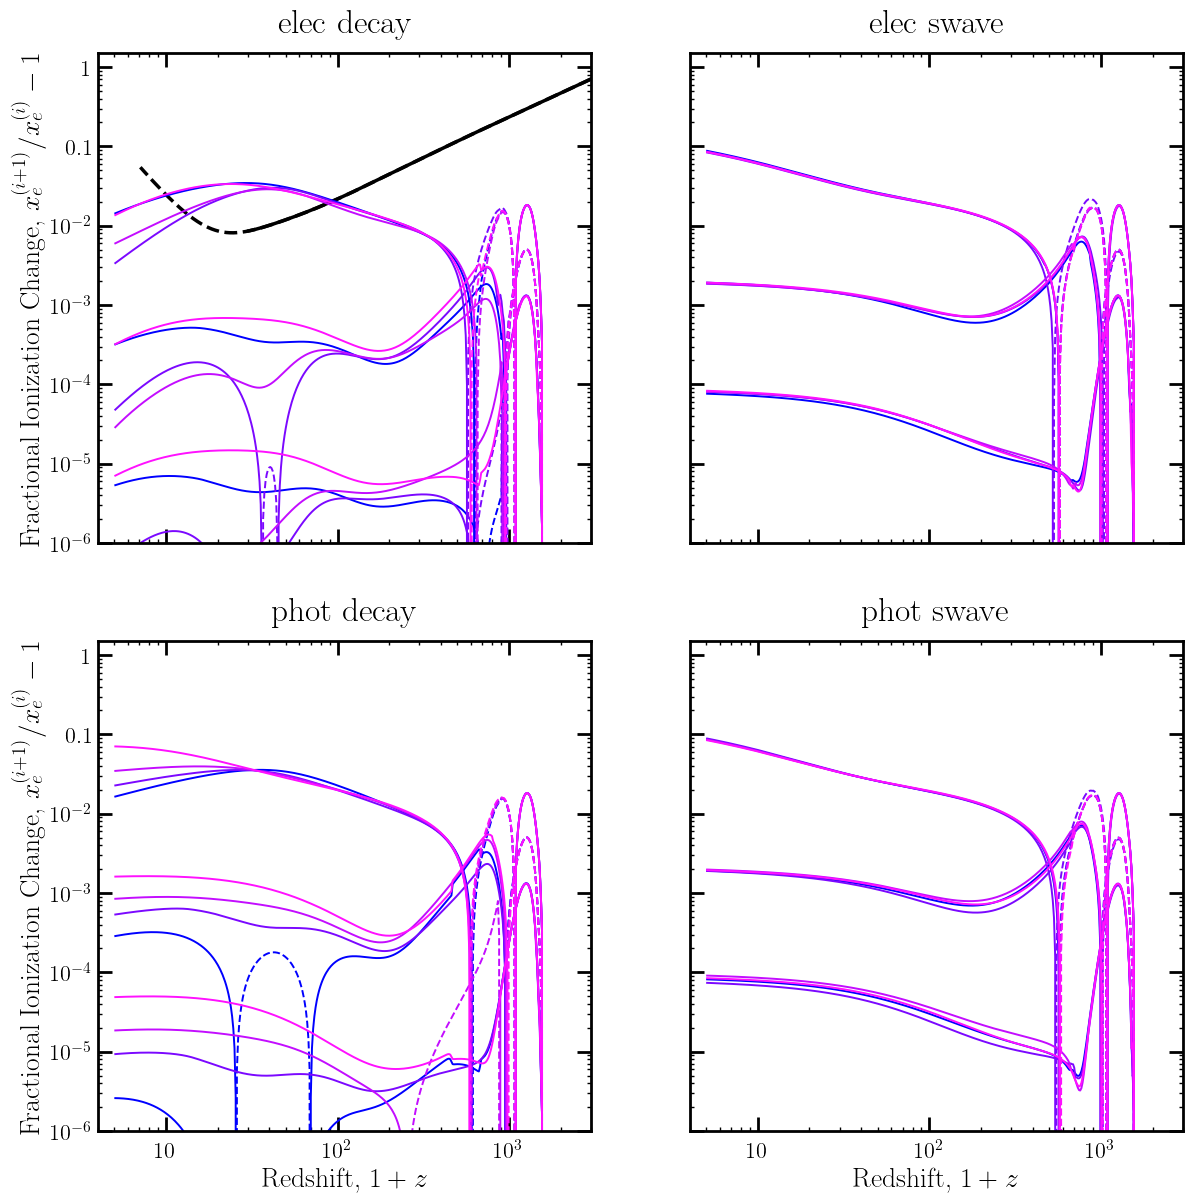

In [1980]:
eng = iter1[key][1][0]['distortion'].eng
rs_vec = iter1[key][1][0]['rs']
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

fig, axarr = plt.subplots(2,2, figsize=(14, 14), sharex=True, sharey=True)

cs = np.linspace(0,1,len(iter1['elec_decay'][1]))**0.66

for i, pri in enumerate(['elec', 'phot']):
    axarr[i][0].set_ylabel(r'Fractional Ionization Change, $x_e^{(i+1)}/x_e^{(i)}-1$', fontsize=20)
    for j, DM_process in enumerate(['decay', 'swave']):
        axarr[i][j].loglog()
        axarr[i][j].set_xlim([4, 3e3])
        axarr[i][j].set_ylim([1e-6, 1.5])
        
        axarr[1][j].set_xlabel(r'Redshift, $1+z$', fontsize=20)
#         axarr[i][j].plot(x_dict[0]['rs'], 
#                  np.abs(x_dict[0]['x'][:,0]
#                   -x_dict[-1]['x'][:,0])/x_dict[0]['x'][:,0], 'k--')
            
        
        model = pri+'_'+DM_process
        
        axarr[i][j].set_title(pri+' '+DM_process)
        
        for k in np.arange(4):
            axarr[i][j].plot(rs_vec, iter1[model][1][k]['x'][:,0]/iter0[model][1][k]['x'][:,0]-1,
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(rs_vec, 1-iter1[model][1][k]['x'][:,0]/iter0[model][1][k]['x'][:,0],
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
            axarr[i][j].plot(rs_vec, iter2[model][1][k]['x'][:,0]/iter1[model][1][k]['x'][:,0]-1,
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(rs_vec, 1-iter2[model][1][k]['x'][:,0]/iter1[model][1][k]['x'][:,0],
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
            axarr[i][j].plot(rs_vec, iter3[model][1][k]['x'][:,0]/iter2[model][1][k]['x'][:,0]-1,
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(rs_vec, 1-iter3[model][1][k]['x'][:,0]/iter2[model][1][k]['x'][:,0],
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#             axarr[i][j].plot(rs_vec, full[model][1][k]['x'][::2,0]/iter2[model][1][k]['x'][:,0]-1,
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(rs_vec, 1-full[model][1][k]['x'][::2,0]/iter2[model][1][k]['x'][:,0],
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#         axarr[i][j].axvline(1.57e3, color='k', linestyle='--')

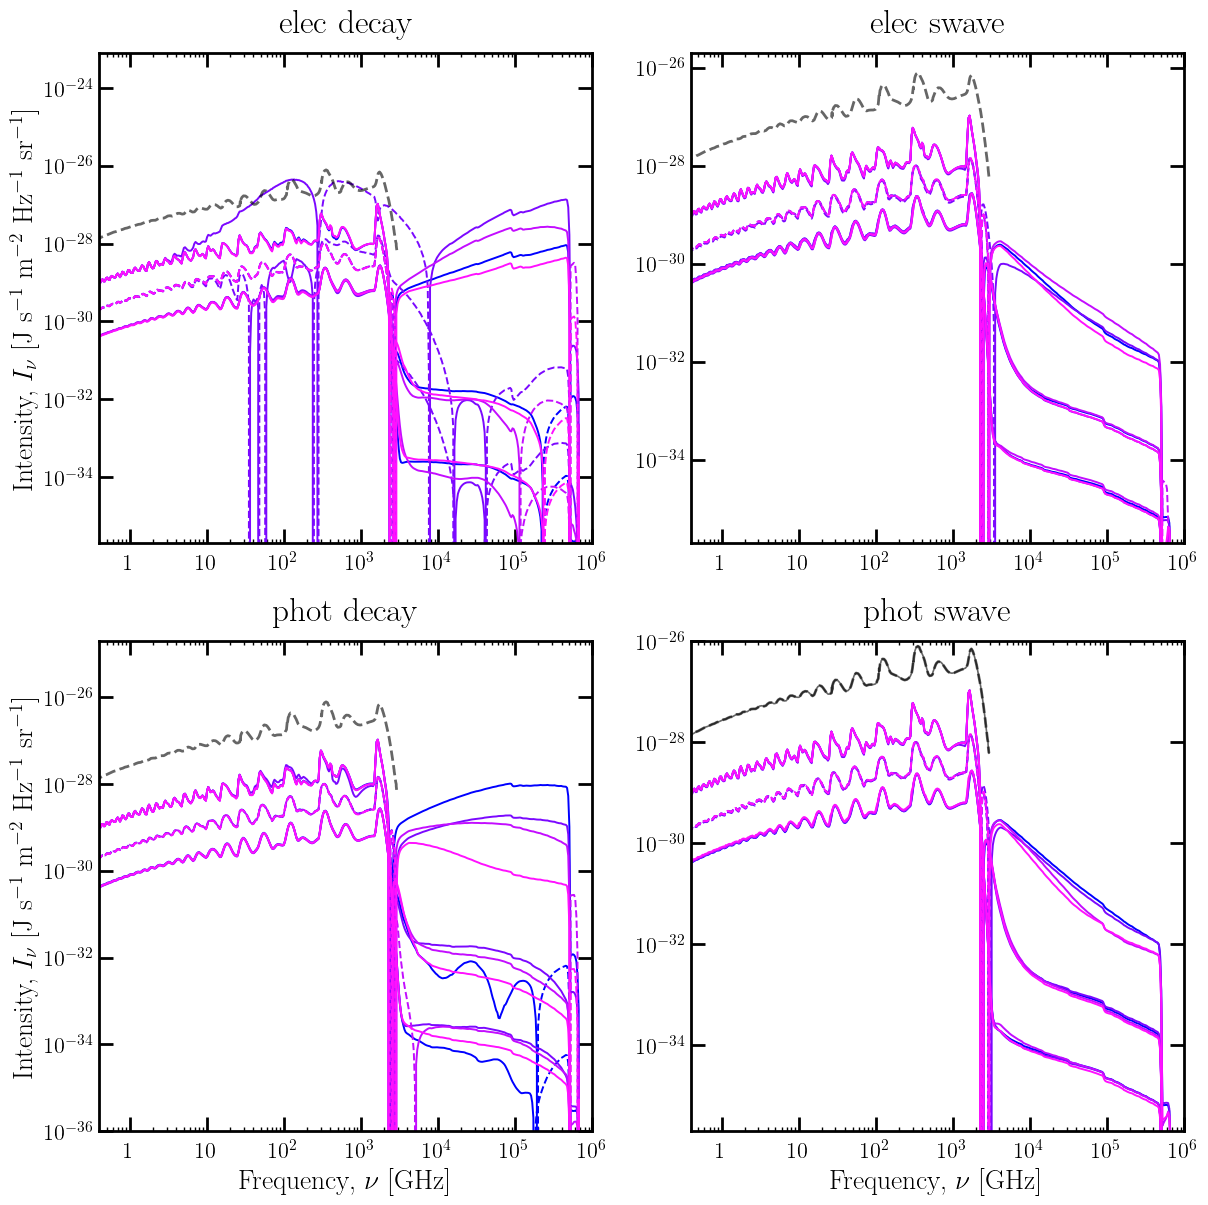

In [272]:
eng = datums[key][1][0]['distortion'].eng
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

fig, axarr = plt.subplots(2,2, figsize=(14, 14))

cs = np.linspace(0,1,len(iter1['elec_decay'][1]))**0.66

axarr[i][j].plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
         linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)

for i, pri in enumerate(['elec', 'phot']):
    axarr[i][0].set_ylabel(r'Intensity, $I_{\nu}$ '+
                           '[J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
    for j, DM_process in enumerate(['decay', 'swave']):
        axarr[i][j].loglog()
        # plt.xscale('log')
        axarr[i][j].set_xlim([4e-1, 1e6])
        
        if i==1:
            axarr[i][j].set_xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
        
        if DM_process == 'swave':
            if pri == 'elec':
                axarr[i][j].set_ylim([2e-36, 2e-26])
            else:
                axarr[i][j].set_ylim([2e-36, 1e-26])
        else:
            if pri == 'elec':
                axarr[i][j].set_ylim([2e-36, 8e-24])
            else:
                axarr[i][j].set_ylim([1e-36, 2e-25])
        
        model = pri+'_'+DM_process
        axarr[i][j].set_title(pri+' '+DM_process)
        
        for k in np.arange(4):
            axarr[i][j].plot(nu/1e9, convert * (iter1[model][1][k]['distortion'].dNdE
                                               -iter0[model][1][k]['distortion'].dNdE),
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(nu/1e9, -convert * (iter1[model][1][k]['distortion'].dNdE
                                                -iter0[model][1][k]['distortion'].dNdE),
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
            axarr[i][j].plot(nu/1e9, convert * (iter2[model][1][k]['distortion'].dNdE
                                               -iter1[model][1][k]['distortion'].dNdE),
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(nu/1e9, -convert * (iter2[model][1][k]['distortion'].dNdE
                                                -iter1[model][1][k]['distortion'].dNdE),
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
            axarr[i][j].plot(nu/1e9, convert * (iter3[model][1][k]['distortion'].dNdE
                                               -iter2[model][1][k]['distortion'].dNdE),
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(nu/1e9, -convert * (iter3[model][1][k]['distortion'].dNdE
                                                -iter2[model][1][k]['distortion'].dNdE),
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
        axarr[i][j].plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k', linestyle='--',
                 linewidth=2.0, label='Chluba+Sunyaev', alpha=0.6)

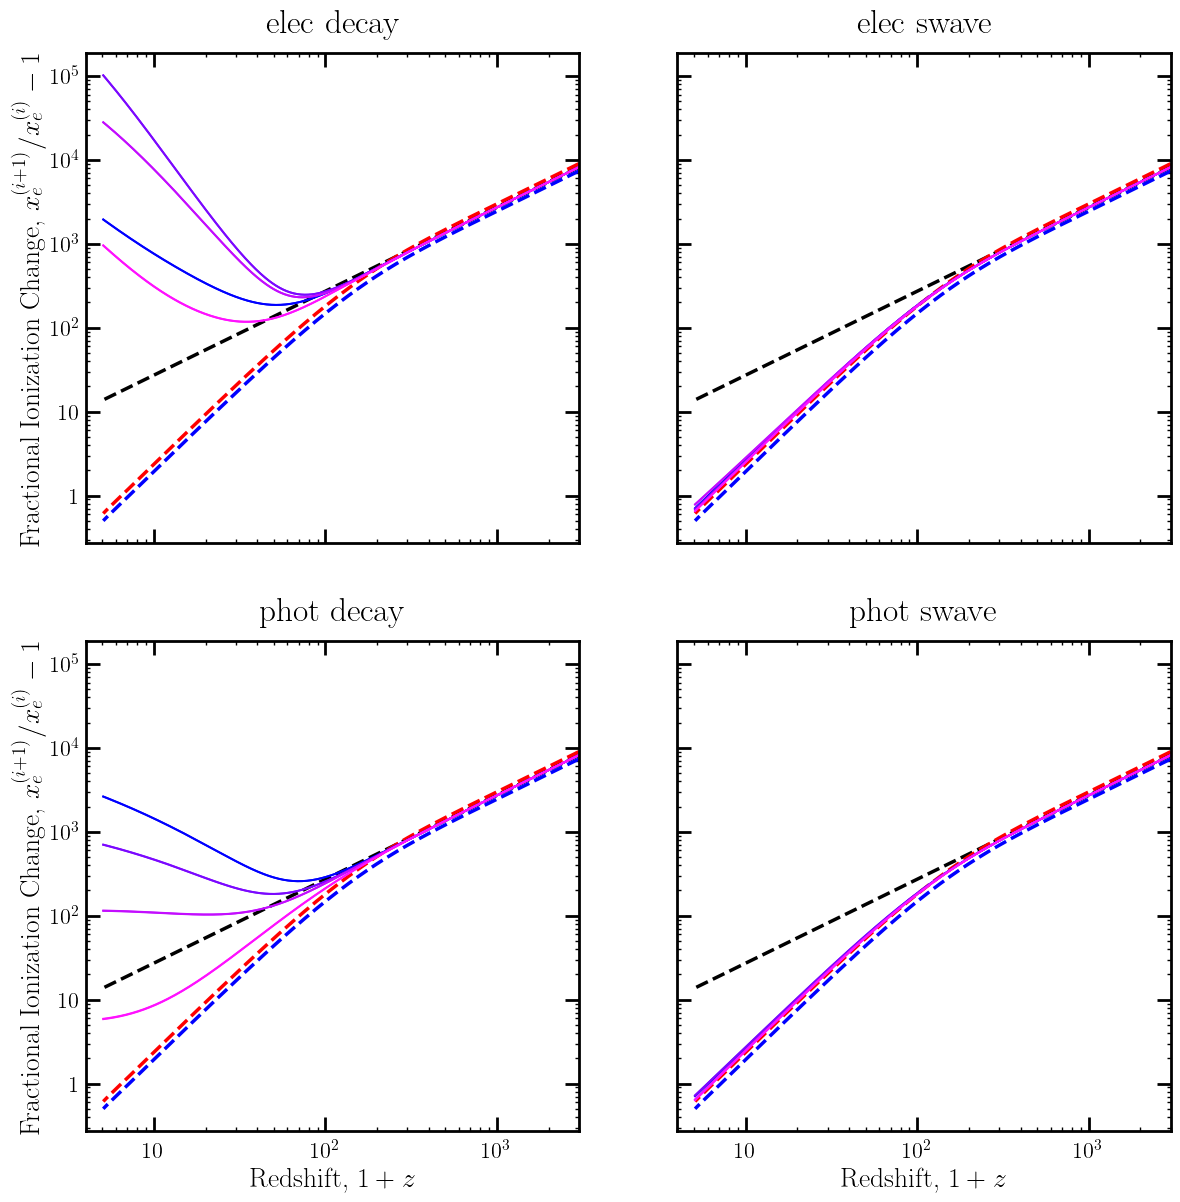

In [597]:
eng = iter1[key][1][0]['distortion'].eng
rs_vec = iter1[key][1][0]['rs']
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

fig, axarr = plt.subplots(2,2, figsize=(14, 14), sharex=True, sharey=True)

cs = np.linspace(0,1,len(iter1['elec_decay'][1]))**0.66

for i, pri in enumerate(['elec', 'phot']):
    axarr[i][0].set_ylabel(r'Fractional Ionization Change, $x_e^{(i+1)}/x_e^{(i)}-1$', fontsize=20)
    for j, DM_process in enumerate(['decay', 'swave']):
        axarr[i][j].loglog()
        axarr[i][j].set_xlim([4, 3e3])
#         axarr[i][j].set_ylim([1e-6, 1.5])
        
        axarr[1][j].set_xlabel(r'Redshift, $1+z$', fontsize=20)
#         axarr[i][j].plot(x_dict[0]['rs'], 
#                  np.abs(x_dict[0]['x'][:,0]
#                   -x_dict[-1]['x'][:,0])/x_dict[0]['x'][:,0], 'k--')
            
        
        model = pri+'_'+DM_process
        
        axarr[i][j].set_title(pri+' '+DM_process)
        
        axarr[i][j].plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--')
        axarr[i][j].plot(rs_vec, 0.9*phys.Tm_std(rs_vec)/phys.kB, 'b--')
        axarr[i][j].plot(rs_vec, 1.1*phys.Tm_std(rs_vec)/phys.kB, 'r--')
        
        for k in np.arange(4):
            axarr[i][j].plot(rs_vec, iter0[model][1][k]['Tm']/phys.kB,
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(rs_vec, iter3[model][1][k]['Tm']/phys.kB,
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)

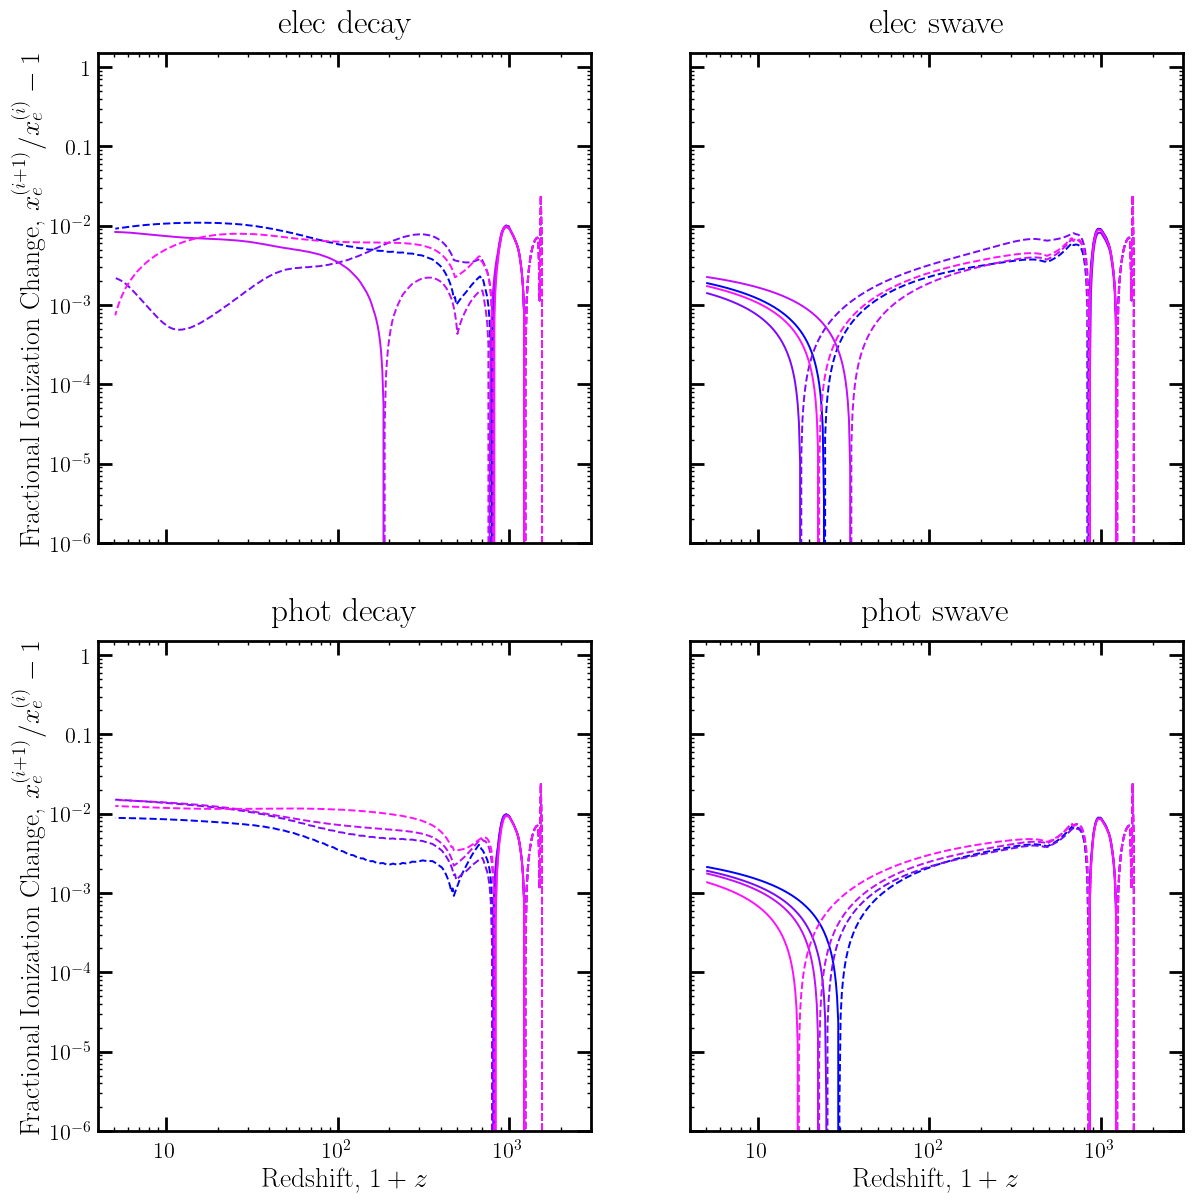

In [1650]:
eng = iter1[key][1][0]['distortion'].eng
rs_vec = iter1[key][1][0]['rs']
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

fig, axarr = plt.subplots(2,2, figsize=(14, 14), sharex=True, sharey=True)

cs = np.linspace(0,1,len(iter1['elec_decay'][1]))**0.66

for i, pri in enumerate(['elec', 'phot']):
    axarr[i][0].set_ylabel(r'Fractional Ionization Change, $x_e^{(i+1)}/x_e^{(i)}-1$', fontsize=20)
    for j, DM_process in enumerate(['decay', 'swave']):
        axarr[i][j].loglog()
        axarr[i][j].set_xlim([4, 3e3])
        axarr[i][j].set_ylim([1e-6, 1.5])
        
        axarr[1][j].set_xlabel(r'Redshift, $1+z$', fontsize=20)
#         axarr[i][j].plot(x_dict[0]['rs'], 
#                  np.abs(x_dict[0]['x'][:,0]
#                   -x_dict[-1]['x'][:,0])/x_dict[0]['x'][:,0], 'k--')
            
        
        model = pri+'_'+DM_process
        
        axarr[i][j].set_title(pri+' '+DM_process)
        
        for k in np.arange(4):
#             axarr[i][j].plot(rs_vec, iter1[model][1][k]['x'][:,0]/iter0[model][1][k]['x'][:,0]-1,
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(rs_vec, 1-iter1[model][1][k]['x'][:,0]/iter0[model][1][k]['x'][:,0],
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#             axarr[i][j].plot(rs_vec, iter2[model][1][k]['x'][:,0]/iter1[model][1][k]['x'][:,0]-1,
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(rs_vec, 1-iter2[model][1][k]['x'][:,0]/iter1[model][1][k]['x'][:,0],
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#             axarr[i][j].plot(rs_vec, iter3[model][1][k]['x'][:,0]/iter2[model][1][k]['x'][:,0]-1,
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(rs_vec, 1-iter3[model][1][k]['x'][:,0]/iter2[model][1][k]['x'][:,0],
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
            axarr[i][j].plot(rs_vec, full[model][1][k]['x'][::2,0]/iter2[model][1][k]['x'][:,0]-1,
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(rs_vec, 1-full[model][1][k]['x'][::2,0]/iter2[model][1][k]['x'][:,0],
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#         axarr[i][j].axvline(1.57e3, color='k', linestyle='--')

In [1657]:
4.3663/phys.width_2s1s_H * 46.26

24.55870549012837

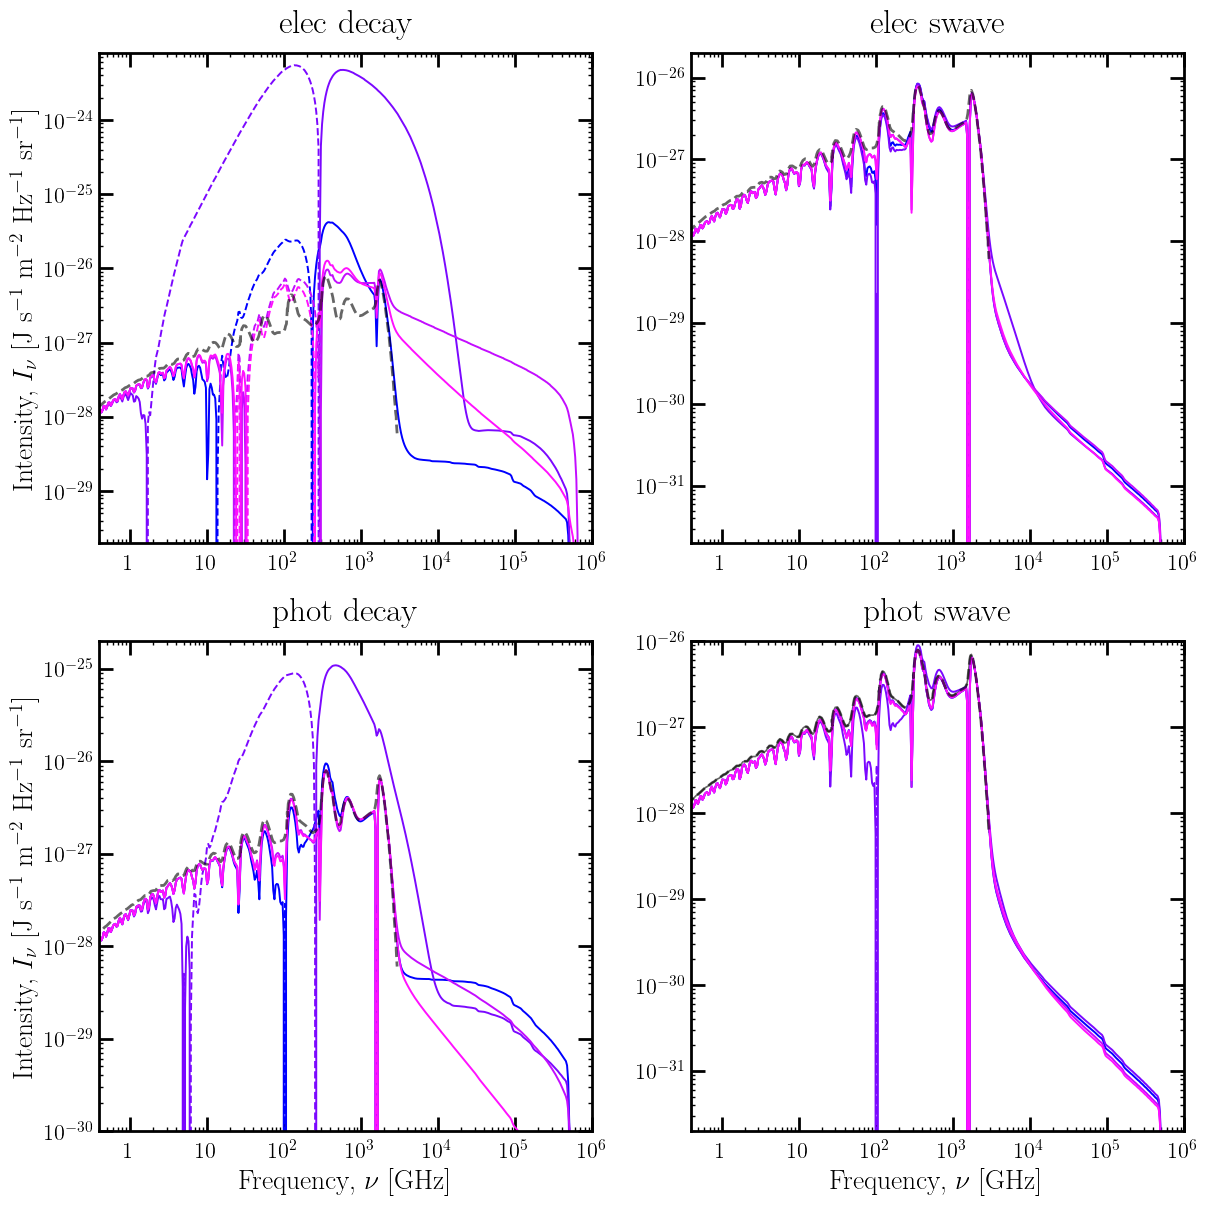

In [1655]:
eng = datums[key][1][0]['distortion'].eng
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

fig, axarr = plt.subplots(2,2, figsize=(14, 14))

cs = np.linspace(0,1,len(iter1['elec_decay'][1]))**0.66

axarr[i][j].plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
         linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)

for i, pri in enumerate(['elec', 'phot']):
    axarr[i][0].set_ylabel(r'Intensity, $I_{\nu}$ '+
                           '[J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
    for j, DM_process in enumerate(['decay', 'swave']):
        axarr[i][j].loglog()
        # plt.xscale('log')
        axarr[i][j].set_xlim([4e-1, 1e6])
        
        if i==1:
            axarr[i][j].set_xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
        
        if DM_process == 'swave':
            if pri == 'elec':
                axarr[i][j].set_ylim([2e-32, 2e-26])
            else:
                axarr[i][j].set_ylim([2e-32, 1e-26])
        else:
            if pri == 'elec':
                axarr[i][j].set_ylim([2e-30, 8e-24])
            else:
                axarr[i][j].set_ylim([1e-30, 2e-25])
        
        model = pri+'_'+DM_process
        axarr[i][j].set_title(pri+' '+DM_process)
        
        for k in np.arange(4):
#             axarr[i][j].plot(nu/1e9, convert * (iter3[model][1][k]['distortion'].dNdE
#                                                -0*iter0[model][1][k]['distortion'].dNdE),
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(nu/1e9, -convert * (iter3[model][1][k]['distortion'].dNdE
#                                                 -0*iter0[model][1][k]['distortion'].dNdE),
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
                
            axarr[i][j].plot(nu/1e9, convert * full[model][1][k]['distortion'].dNdE,
                            color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(nu/1e9, -convert * full[model][1][k]['distortion'].dNdE,
                            color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
    
#             axarr[i][j].plot(nu/1e9, convert * (full[model][1][k]['distortion'].dNdE
#                                                -iter3[model][1][k]['distortion'].dNdE),
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(nu/1e9, -convert * (full[model][1][k]['distortion'].dNdE
#                                                 -iter3[model][1][k]['distortion'].dNdE),
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
        axarr[i][j].plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k', linestyle='--',
                 linewidth=2.0, label='Chluba+Sunyaev', alpha=0.6)
        
# plt.savefig(fig_dir+'distortion_grid.pdf')

In [146]:
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297

models = ['elec_decay', 'elec_swave', 'phot_decay', 'phot_swave']
data2 = {model : [] for model in models}

for pri in ['elec', 'phot']:
    for DM_process in ['decay', 'swave']:
        
        model = pri+'_'+DM_process
        print('starting', model)
        
        if pri=='elec':
            if DM_process=='decay':
                mDM_list = 2*(10**log10eng + phys.me)
            else:
                mDM_list = 10**log10eng + phys.me

        elif pri=='phot':
            if DM_process=='decay':
                mDM_list = 2*10**log10eng
            else:
                mDM_list = 10**log10eng
        
        for mDM in tqdm(mDM_list[5::10]):
            
            param = param_bound(mDM, DM_process, pri)

            goods = main.evolve(
                DM_process=DM_process, mDM=mDM,
                lifetime=param,
                sigmav = param,
                primary=pri+'_delta',
                start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
                coarsen_factor=coarsen_factor, backreaction=True,
                distort=True, recfast_TLA=True,
                fexc_switch = True, reprocess_distortion=True, nmax=nmax
            )
            
            data2[model].append(goods)
            
# pickle.dump(data2, open('/Users/gregoryridgway/Desktop/Data/'+
#                        'scan_nmax10_every10th_5.dat','wb'))

starting elec_decay


/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_58792/567884332.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for mDM in tqdm(mDM_list[5::10]):


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Scratch Work

In [136]:
%autoreload
DM_run_fcont = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor, backreaction=False,
    cross_check=False, distort=False, recfast_TLA=True,
    fexc_switch=True, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

0.008017952653325142
0.32658172814614705
0.6643936413646182
0.35060232080204035


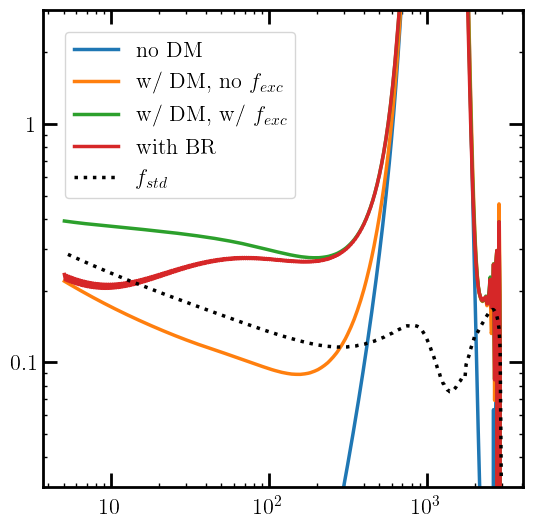

In [298]:
plt.figure()
plt.loglog()
plt.ylim([3e-2, 3])

norm_facs = (
    phys.nB * baseline['rs']**3 /
    (.001*coarsen_factor / phys.hubble(baseline['rs'])) / 
    phys.inj_rate('decay', baseline['rs'], mDM, lifetime=lifetime)
)

tmp_base = np.squeeze(
    baseline['distortions'].toteng('eng', np.array([1e-12,10.2]))
) * norm_facs

strings = ['no DM', 'w/ DM, no $f_{exc}$', 'w/ DM, w/ $f_{exc}$', 'with BR']
# for tmp in [DM_run, DM_run_withf]:
for lab, tmp in zip(strings,[baseline, DM_run, DM_run_withf, DM_run_withf2]):
    print(tmp['distortion'].toteng())
    f_cont_input = np.squeeze(
        tmp['distortions'].toteng('eng', np.array([1e-12,10.2]))
    ) * norm_facs
    
#     plt.plot(tmp['rs'][1:], f_cont_input[1:]-tmp_base[1:])
    plt.plot(tmp['rs'][1:], f_cont_input[1:], label=lab)
    
# plt.plot(DM_run_fcont['rs'][1:], DM_run_fcont['f']['cont'][1:],
#          label='main.evolve(), no distortion')
    
plt.plot(tmp['rs'][1:], phys.f_std(
    mDM, tmp['rs'][1:], pri, DM_process, channel='cont'),
        'k:', label = '$f_{std}$')

plt.legend()

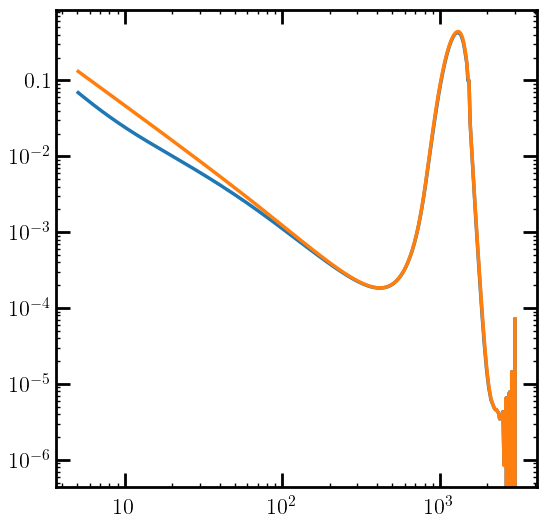

In [302]:
plt.figure()
plt.loglog()
plt.plot(DM_run_withf_withDf2['rs'], DM_run_withf_withDf2['distortions'].toteng())
plt.plot(DM_run_withf['rs'], DM_run_withf['distortions'].toteng())

In [812]:
import pickle

input_dir = '/Users/gregoryridgway/Dropbox (MIT)/DarkHistory_V2/data/'
input_dir = '/Users/gregoryridgway/Desktop/Data/'
data = pickle.load(open(input_dir+
                        'iter0_elec_decay_nmax100_endrs5_03_22.dat','rb'))  #_03_22

In [203]:
# spectra of lowengphots
ind = 5
tmp = data[1][ind]['lowengphot'].copy()

# mask out ionizing photons
mask = np.array(list(map(float,tmp.eng<13.6)))
tmp._grid_vals = tmp._grid_vals * mask

# redshift then sum
tmp.redshift(1.)
tmp = tmp.sum_specs()

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

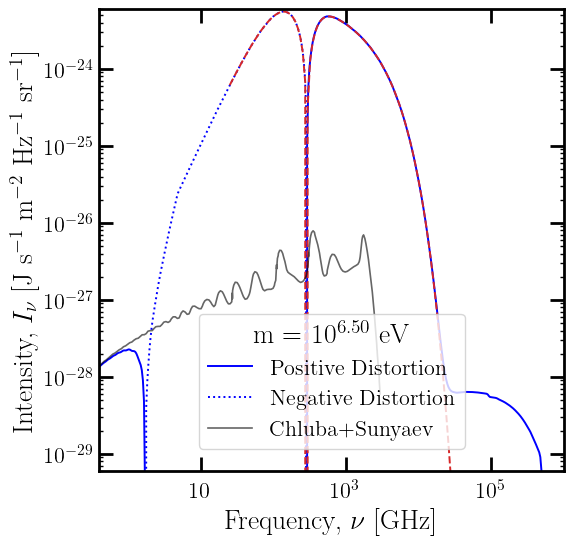

In [208]:
eng = baseline['distortion'].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure(figsize=(6,6))
plt.loglog()
plt.xlim([4e-1, 1e6])
plt.ylim([6e-30, 6e-24])

# DH generated data
# plt.plot(nu/1e9, convert * baseline['distortion'].dNdE,
#          color='C0', linewidth=1.4, label='no DM')
# plt.plot(nu/1e9, convert * DMrun['distortion'].dNdE,
#          color='blue', linewidth=1.4, label='w/ DM, (+)')
# plt.plot(nu/1e9, -convert * DM_run['distortion'].dNdE,
#          color='red', linewidth=1.4, label='w/ DM, (-)')

plt.plot(nu/1e9, convert * data[1][ind]['distortion'].dNdE,
         color=(0,0,1), linewidth=1.4, label='Positive Distortion')
plt.plot(nu/1e9, -convert * data[1][ind]['distortion'].dNdE,
         color='blue', linestyle=':', linewidth=1.4, label='Negative Distortion')

plt.plot(tmp.eng/hplanck/1e9, phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
         color='C3', linestyle='--', linewidth=1.4)
plt.plot(tmp.eng/hplanck/1e9, -phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
         color='C3', linestyle='--', linewidth=1.4)


# Data from Jens Chluba et al's papers
plt.plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
         linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)
# plt.plot(n10_data[:,0], n10_data[:,1], color='k',
#          linewidth=2.0, linestyle='--', label='Jens+')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
# plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
# plt.plot(jens_data[:,0], jens_data[:,1], color='k', linewidth=2.0, linestyle='--')

string = '{:.2f}'.format(np.log10(data[0][ind][0]))
string = r'm = $10^{'+string+'}$ eV'
plt.legend(title=string)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

In [822]:
tmp = [data[0].flatten(), []]

for d in data[1]:
    tmp[1].append(d['distortion'])
    
pickle.dump(tmp, open('/Users/gregoryridgway/Dropbox (MIT)/DarkHistory_V2/data/iter0_elec_decay_nmax100_endrs5_03_22.dat', 'wb'))

In [420]:
%autoreload

nmax = 10
n = 3
rs = 1300

Tm = phys.Tm_std(rs)
xe = phys.xHII_std(rs)
nH = phys.nH * rs**3
Tr = phys.TCMB(rs)
x_nl = np.arange(nmax*(nmax+1)//2)
dt = .001*16/phys.hubble(rs)
nB = phys.nB * rs**3

Thetas = bf.populate_Theta(nmax)
bf.net_spec_n(n, Tm, xe, x_nl, nH, Thetas, Tr)

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

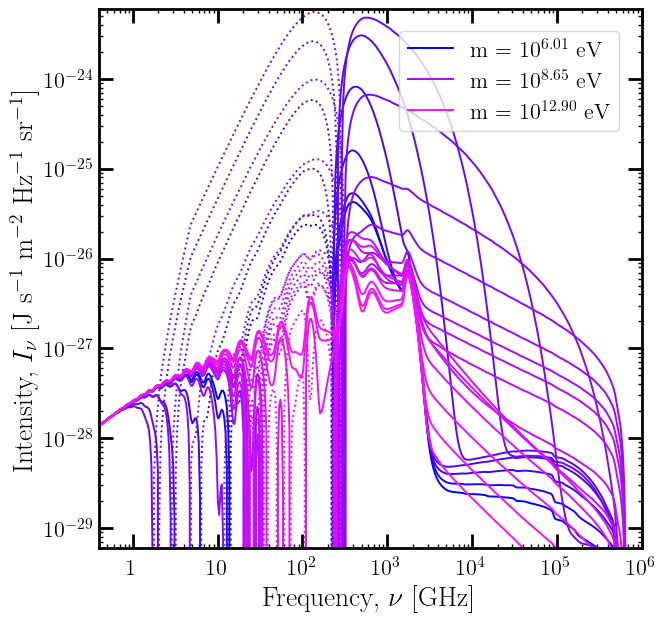

In [827]:
import pickle

input_dir = '/Users/gregoryridgway/Dropbox (MIT)/DarkHistory_V2/data/'
# input_dir = '/Users/gregoryridgway/Desktop/Data/'
data = pickle.load(open(input_dir+
                        'iter0_elec_decay_nmax100_endrs5_03_22.dat','rb'))  #_03_22

eng = data[1][0].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure(figsize=(7, 7))
plt.loglog()
plt.xlim([4e-1, 1e6])
plt.ylim([6e-30, 6e-24])

# DH generated data

cs = np.linspace(0,1,len(data[0]))**0.66

for i in np.arange(len(data[0])):
    
    string = '{:.2f}'.format(np.log10(data[0][i]))
    string = r'm = $10^{'+string+'}$ eV'
    
    if i==0 or i==19 or i==10:
        plt.plot(nu/1e9, convert * data[1][i].dNdE,
                 color=(cs[i],cs[i]/15,1), linewidth=1.4, label=string)
    else:
        plt.plot(nu/1e9, convert * data[1][i].dNdE,
                 color=(cs[i],cs[i]/15,1), linewidth=1.4)
        
    plt.plot(nu/1e9, -convert * data[1][i].dNdE,
             color=(cs[i],cs[i]/15,1), linewidth=1.4, linestyle=':')

plt.legend()

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

In [341]:
Thetas['dn'][n][l.flatten()]

array([[1.55841571e+00, 1.55841571e+00, 1.55841571e+00, ...,
        4.48178019e-21, 3.58388131e-21, 2.91898606e-21],
       [5.33678627e-01, 5.33678627e-01, 5.33678627e-01, ...,
        8.21533248e-37, 5.49343083e-37, 3.79680792e-37],
       [1.06735725e-01, 1.06735725e-01, 1.06735725e-01, ...,
        3.93248850e-46, 2.40460475e-46, 1.53097094e-46]])

Make sure this isn't coming from low energy photons.

In [370]:
np.dot(np.arange(3)[:, np.newaxis] * np.ones((3,10)), np.arange(10))

array([ 0., 45., 90.])

In [170]:
1/phys.hubble(4)/(np.pi*1e7)/1e9

3.190496146330368

In [365]:
config.load_data('bnd_free')['h_ary'][n].shape

(550,)

In [162]:
tau_bound_elec_CMB(5e6)

2.766300429473599e+24

In [411]:
Tr

100

In [ ]:
data[1][i]['distortions'].toteng()

6.013678810996636 10.646476617926604
6.021675273784309 10.715816751501887
6.044199314851133 11.119177843298438
6.103940160187505 14.092443410780149
6.242237103503343 31.944300903226235
6.496477552807342 91.37484634646543
6.8568684175901975 42.59095579284164
7.279337348227743 20.884583518226314
7.7287777518534595 15.876913993520763
8.188346916909495 12.750747859168726
8.651503224301859 11.783060938842521
9.115903072559847 11.337466320892712
9.58073079837503 11.05955213617763
10.045705368042224 10.655430960373762
10.510730288472578 10.52761330724029
10.975772468233327 10.433373330038625
11.440820563561855 10.318508343281117
11.905870686355396 10.208434482066705
12.370921504021188 10.160226743531343
12.9025360460621 10.142628378555656


Text(0, 0.5, 'Energy Injected into Distortion')

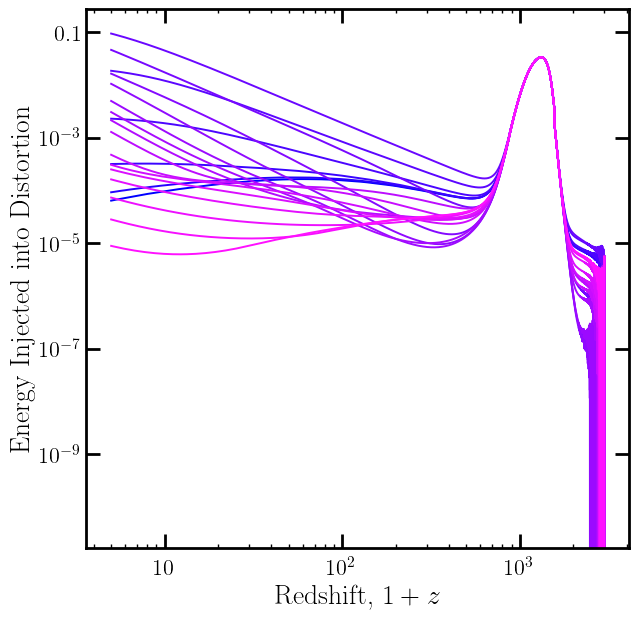

In [165]:
plt.figure(figsize=(7, 7))
plt.loglog()

cs = np.linspace(0,1,len(data[0]))**0.66


for i in np.arange(len(data[0])):
    print(np.log10(data[0][i][0]), sum(data[1][i]['distortions'].toteng()))
    plt.plot(data[1][i]['rs'], data[1][i]['distortions'].toteng(),
             color=(cs[i],cs[i]/15,1), linewidth=1.4)

# plt.legend(loc=2)

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Energy Injected into Distortion', fontsize=20)

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(14, 7))
axarr[0].loglog()
axarr[0].set_ylim([1e-22, 1e-8])

axarr[0].plot(DMrun_withf['rs'], DMrun_withf['MLA'][0][1:], label=r'$\alpha$, no $f_{exc}$')
axarr[0].plot(DMrun_withf['rs'], DMrun_withf['MLA'][1][1:], label=r'$\beta$, no $f_{exc}$')

axarr[0].plot(DMrun['rs'], DMrun['MLA'][0][1:], label=r'$\alpha$, w/ $f_{exc}$')
axarr[0].plot(DMrun['rs'], DMrun['MLA'][1][1:], label=r'$\beta$, w/ $f_{exc}$')

# axarr[0].plot(DM_run0['rs'], phys.alpha_recomb(Tm_vec, 'HI') + 0*xe_vec**2*nH_vec)
# rate = phys.beta_ion(Tr_vec, 'HI') * x2_vec
# axarr[0].plot(DM_run0['rs'], rate)

axarr[0].set_xlabel('Redshift, $1+z$')
axarr[0].set_ylabel('Recombination/Ionization Rates, [$s^{-1}$]')
axarr[0].legend()

# plt.plot(DM_run_withf0['rs'], np.abs(DM_run_withf0['MLA'][0][1:]/DM_run0['MLA'][0][1:]-1),
#          label=r'$\alpha$')


axarr[1].loglog()
axarr[1].set_ylim([1e-3, 1])
axarr[1].plot(DMrun_withf['rs'], DMrun_withf['MLA'][1][1:]/DMrun['MLA'][1][1:]-1,
         label=r'$\Delta \beta$')

axarr[1].axvline(600, linestyle='--', color='k', label=r'$1+z=600$')

axarr[1].legend()
axarr[1].set_xlabel('Redshift, $1+z$')
axarr[1].set_ylabel('Fractional Difference in Ionization Rate')

In [140]:
mDM = data[0][ind][0]

MLA_funcs = np.array([
    interp1d(data[1][ind]['rs'], data[1][ind]['MLA'][0][1:]),
    interp1d(np.log(data[1][ind]['rs']), np.log(data[1][ind]['MLA'][1][1:]))
])

f_raw = {key: interp1d(data[1][ind]['rs'], data[1][ind]['f'][key],
                       bounds_error=False, fill_value = (0,0))
         for key in data[1][ind]['f'].keys()}

def f_H_ion(rs, xHI, xHeI, xHeII):
    return f_raw['H ion'](rs)
def f_heat(rs, xHI, xHeI, xHeII):
    return f_raw['heat'](rs)
def f_H_exc(rs, xHI, xHeI, xHeII):
    return f_raw['Lya'](rs)

def rate_func_eng(rs):
    return phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=tau_bound_elec_CMB(mDM))

rs_vec = np.exp(np.arange(np.log(3e3),np.log(5.4),-.001))

iterated = tla.get_history(
    rs_vec, high_rs=np.inf,
    f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
    injection_rate=rate_func_eng,
    recfast_TLA=False,
    alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
    mxstep=10000, rtol=1e-8
)

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_22424/3134640582.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ind in tqdm(np.arange(len(data[0]))):


  0%|          | 0/20 [00:00<?, ?it/s]

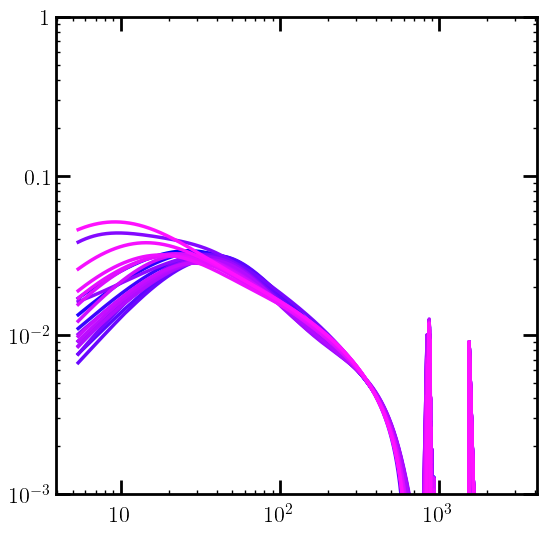

In [147]:
plt.figure()
plt.loglog()
plt.ylim([1e-3,1])

for ind in tqdm(np.arange(len(data[0]))):

    mDM = data[0][ind][0]

    MLA_funcs = np.array([
        interp1d(data[1][ind]['rs'], data[1][ind]['MLA'][0][1:]),
        interp1d(np.log(data[1][ind]['rs']), np.log(data[1][ind]['MLA'][1][1:]))
    ])

    f_raw = {key: interp1d(data[1][ind]['rs'], data[1][ind]['f'][key],
                           bounds_error=False, fill_value = (0,0))
             for key in data[1][ind]['f'].keys()}

    def f_H_ion(rs, xHI, xHeI, xHeII):
        return f_raw['H ion'](rs)
    def f_heat(rs, xHI, xHeI, xHeII):
        return f_raw['heat'](rs)
    def f_H_exc(rs, xHI, xHeI, xHeII):
        return f_raw['Lya'](rs)

    def rate_func_eng(rs):
        return phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=tau_bound_elec_CMB(mDM))

    rs_vec = np.exp(np.arange(np.log(3e3),np.log(5.4),-.001))

    iterated = tla.get_history(
        rs_vec, high_rs=np.inf,
        f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
        injection_rate=rate_func_eng,
        recfast_TLA=False,
        alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
        mxstep=10000, rtol=1e-8
    )

    plt.plot(rs_vec, iterated[:,1]/data[1][ind]['x'][:6320,0]-1,
            color=(cs[ind],cs[ind]/15,1))
# plt.plot(baseline['rs'], baseline['x'][:,0])
# plt.plot(rs_vec, iterated[:,1])
# plt.plot(rs_vec, iterated_withf[:,1])

TODO
- check the baseline scenario (no DM injection). See how much comes from difference between BB and truth, but also numerical precision (n=100 approx)
- one second iteration to show that the iteration procedure works
- Include reionization, make sure it's consistent with Planck's 2sigma region, see if dominant contribution comes from latest times (that we're not keeping track of)
- understand where the features come from

$\chi \to e^+ e^-$

In [772]:
tmp = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                            'iter0_elec_swave_nmax10_endrs5.dat','rb'))

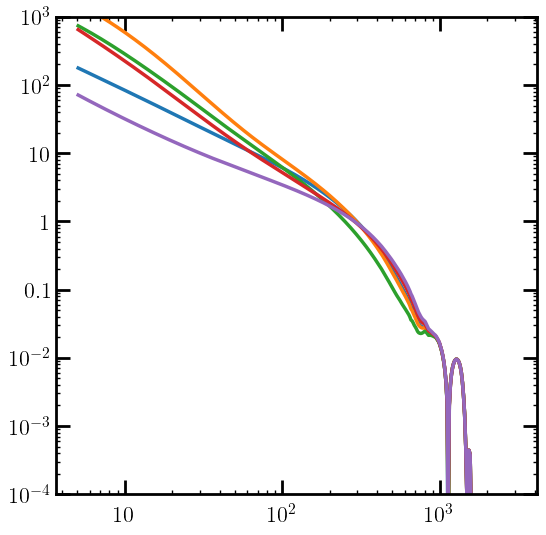

In [773]:
f, axarr = plt.subplots(1,2,figsize=(10,5))
axarr[1].loglog()
plt.ylim([1e-4,1000])
for i in np.arange(5):
#     plt.plot(tmp[1][i]['rs'], tmp[1][i]['distortions'].toteng())
    axarr[1].plot(tmp[1][i]['rs'], np.abs(
        tmp[1][i]['x'][:,0]/phys.xHII_std(tmp[1][i]['rs'])-1))

In [198]:
baseline = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                            'baseline_elec_decay_nmax20_endrs900.dat','rb'))

# goods = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
#                             'iter0_phot_decay_nmax10_endrs5.dat','rb'))
# sum(np.isnan(baseline[1][0]['distortions'].toteng()))

Text(0.5, 1.0, 'rs = 1798')

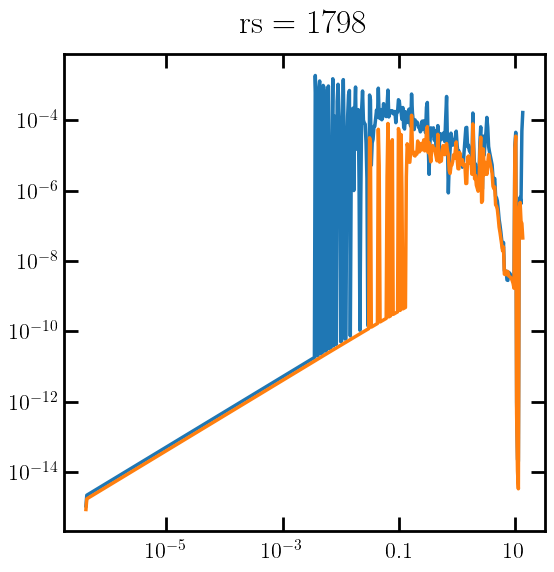

In [214]:
plt.figure()
plt.loglog()
ind = 32
plt.plot(baseline[1][0]['distortions'][ind].eng, np.abs(baseline[1][0]['distortions'][ind].dNdE))
plt.plot(baseline2[1][0]['distortions'][ind].eng, np.abs(baseline2[1][0]['distortions'][ind].dNdE))
plt.title('rs = '+str(round(baseline[1][0]['distortions'][ind].rs)))

In [318]:
nmax = 100
cf = 16

input_str = 'n'+str(nmax)+'cf'+str(cf)

data[input_str] = main.evolve(
    DM_process='decay', mDM=10**6.01,
    lifetime=2.7e24 * 1e20,
    primary='elec_delta',
    start_rs = 3e3, high_rs = 1.555e3, end_rs=5,
    coarsen_factor=cf, backreaction=True,
    distort=True,
    nmax=nmax,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=False,
    cross_check=False
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


KeyboardInterrupt: 

In [293]:
inputs = [(15,16), (10,16), (15,8), (20,8), (20,4)]

In [280]:
inputs = [(15,16), (10,16), (15,8)]
for pair in inputs:
    nmax = pair[0]
    cf = pair[1]
    
    input_str = 'n'+str(nmax)+'cf'+str(cf)
    
    data[input_str] = main.evolve(
        DM_process='decay', mDM=10**6.01,
        lifetime=2.7e24 * 1e20,
        primary='elec_delta',
        start_rs = 3e3, high_rs = 1.555e3, end_rs=1100,
        coarsen_factor=cf, backreaction=True,
        distort=True,
        nmax=nmax,
        recfast_TLA=True,
        # MLA_funcs=MLA_funcs, 
        fexc_switch = True, reprocess_distortion=True,
        cross_check=False
    )

  0%|          | 0/126.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


Text(0.5, 0, 'Redshift, $1+z$')

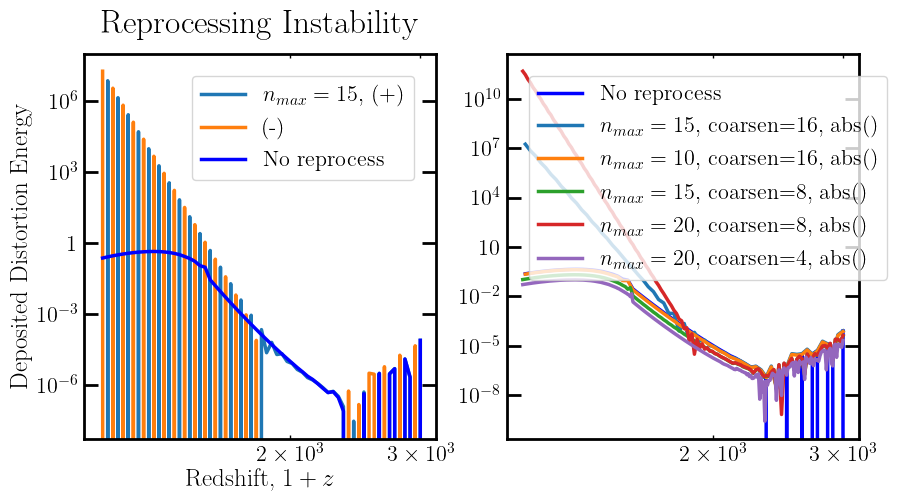

In [294]:
f, axarr = plt.subplots(1,2, figsize=(10,5), sharex=True)

# first plot
axarr[0].loglog()
axarr[0].plot(data['n15cf16']['rs'], data['n15cf16']['distortions'].toteng(),
         label='$n_{max}=15$, (+)')
axarr[0].plot(data['n15cf16']['rs'], -data['n15cf16']['distortions'].toteng(),
         label='(-)')
axarr[0].plot(data['stable']['rs'], data['stable']['distortions'].toteng(),
         label='No reprocess', color='blue')


# second plot
axarr[1].loglog()

axarr[1].plot(data['stable']['rs'], data['stable']['distortions'].toteng(),
         label='No reprocess', color='blue')

for pair in inputs:
    s = 'n'+str(pair[0])+'cf'+str(pair[1])

    axarr[1].plot(data[s]['rs'], np.abs(data[s]['distortions'].toteng()),
             label='$n_{max}='+str(pair[0])+'$, coarsen='+str(pair[1])+', abs()')
    
axarr[1].legend()

axarr[0].legend()
axarr[0].set_title('Reprocessing Instability')
axarr[0].set_ylabel('Deposited Distortion Energy')
axarr[0].set_xlabel('Redshift, $1+z$')

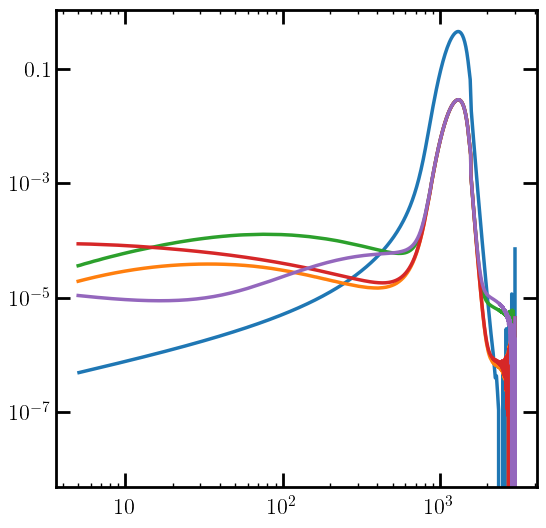

In [27]:
plt.figure()
plt.loglog()
# plt.plot(baseline[1][0]['rs'], baseline[1][0]['distortions'].toteng())
for i in np.arange(4):
    plt.plot(goods[1][i]['rs'], goods[1][i]['distortions'].toteng())

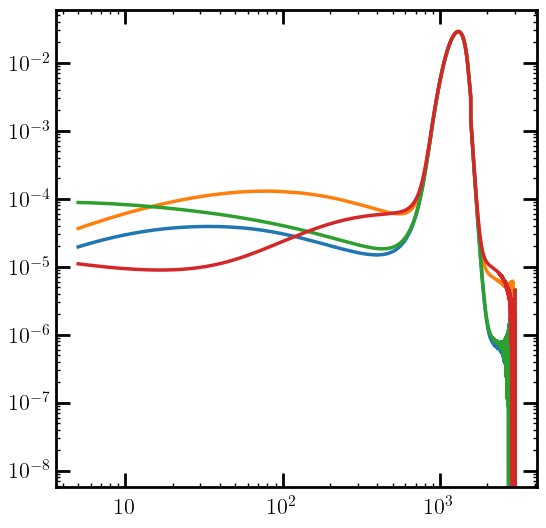

In [28]:
plt.figure()
plt.loglog()
# plt.plot(baseline[1][0]['rs'], baseline[1][0]['distortions'].toteng())
for i in np.arange(4):
    plt.plot(goods[1][i]['rs'], goods[1][i]['distortions'].toteng())

In [196]:
junk = main.evolve(
    DM_process='decay', mDM=10**6.013678810996636,
    lifetime=2.69747957975171e24 * 1e20,
    primary='elec_delta',
    start_rs = 3e3, high_rs = 1.555e3, end_rs=1100,
    coarsen_factor=8, backreaction=True,
    distort=True,
    nmax=10,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=True,
    cross_check=False
)

  0%|          | 0/126.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


In [1040]:
%autoreload
tmp0 = main.evolve(
    DM_process='decay', mDM=10**6.01,
    lifetime=2.7e24,
    primary='elec_delta',
    start_rs = 3e3, high_rs = 1.555e3, end_rs=5,
    coarsen_factor=cf, backreaction=True,
    distort=True,
    nmax=20,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=False,
    cross_check=False
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:477: RuntimeWarning: overflow encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:481: RuntimeWarning: overflow encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHist

In [1164]:
%autoreload
tmp['noRE_noDM'] = main.evolve(
    DM_process='decay', mDM=10**6.01,
    lifetime=2.7e24*1e20,
    primary='elec_delta',
    start_rs = 2e3, high_rs = 1.555e3, end_rs=700,
    coarsen_factor=cf, backreaction=True,
    distort=True,
    nmax=20,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=True,
    cross_check=False
)

  0%|          | 0/66.0 [00:00<?, ?it/s]

[0. 0. 0. 0. 0.]
[-4.07454911e-10 -1.04000711e-11 -4.64432633e-12 -8.52093839e-12
 -1.24540570e-11]
[2.78268299e-06 6.37262542e-08 2.77638282e-08 4.98421729e-08
 7.30752039e-08]
[3.73316470e-06 8.16042348e-08 5.48314003e-08 8.80875725e-08
 7.47985563e-08]
[5.33070014e-06 1.10581863e-07 7.77877196e-08 1.21838807e-07
 9.94833779e-08]
[8.91481995e-06 1.71462749e-07 1.10412134e-07 1.52891598e-07
 1.51653289e-07]
[1.42991646e-05 2.50111008e-07 1.57671001e-07 2.29590380e-07
 2.06419246e-07]
[2.32758832e-05 3.76347909e-07 2.23647466e-07 3.29158361e-07
 2.96430239e-07]
[3.82858196e-05 5.69918789e-07 3.34808628e-07 4.68388477e-07
 4.28196113e-07]
[6.33821100e-05 8.69422784e-07 4.89463991e-07 6.88295162e-07
 6.19210647e-07]
[1.05843534e-04 1.33775632e-06 7.28509191e-07 1.00930133e-06
 9.05577533e-07]
[1.78062576e-04 2.07201378e-06 1.09373054e-06 1.49040758e-06
 1.33162207e-06]


KeyboardInterrupt: 

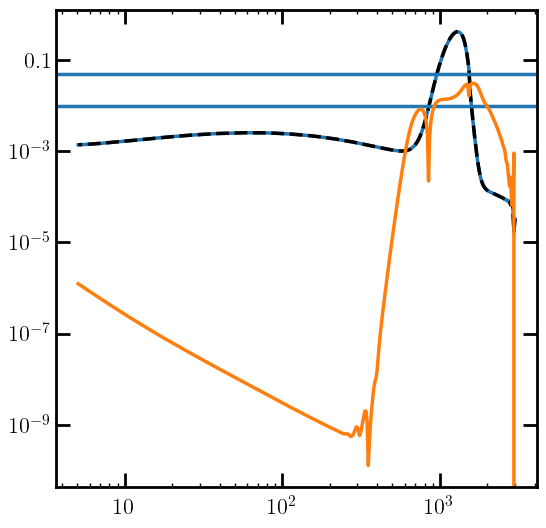

In [1047]:
plt.figure()
plt.loglog()
plt.plot(tmp2['rs'], tmp2['distortions'].toteng())
plt.plot(tmp0['rs'], tmp0['distortions'].toteng(), 'k--')
plt.axhline(.05)
plt.axhline(.01)

plt.plot(tmp['rs'], np.abs(tmp2['distortions'].toteng()/tmp0['distortions'].toteng()-1))
# plt.plot(tmp['rs'], np.abs(tmp['distortions'].toteng()/tmp0['distortions'].toteng()-1))

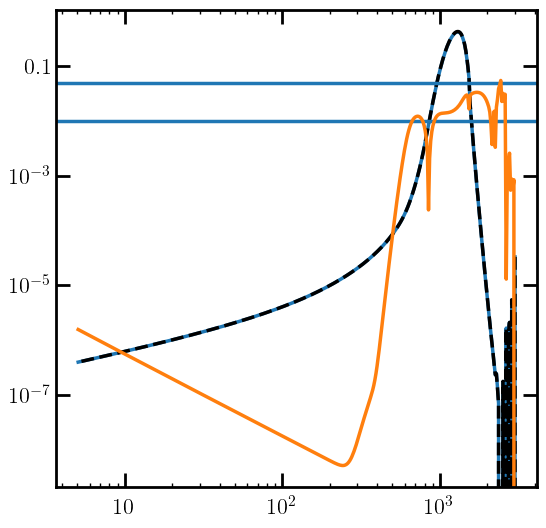

In [1051]:
plt.figure()
plt.loglog()
plt.plot(tmp['rs'], tmp['distortions'].toteng())
plt.plot(tmp1['rs'], tmp1['distortions'].toteng(), 'k--')
plt.axhline(.05)
plt.axhline(.01)

plt.plot(tmp['rs'], np.abs(tmp['distortions'].toteng()/tmp1['distortions'].toteng()-1))

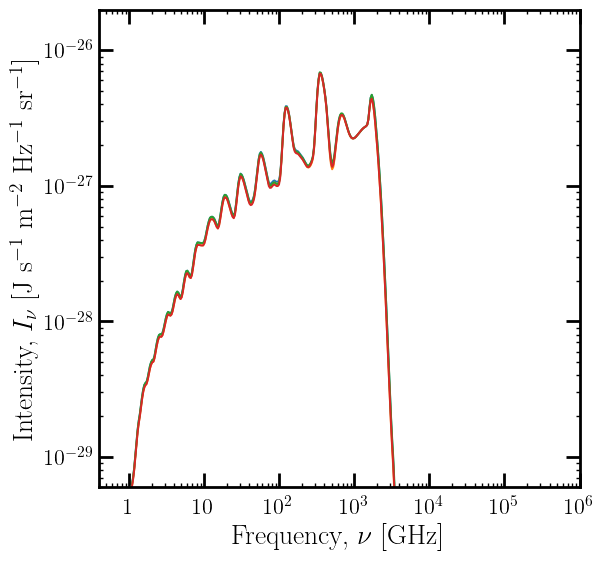

In [1091]:
plt.figure()
ax = plt.gca()

plot_distortion(ax, tmp['noRE_noDM'])
plot_distortion(ax, tmp['RE_noDM'])
plot_distortion(ax, tmp['noRE_DM'])
plot_distortion(ax, tmp['RE_DM'])

In [1115]:
tmp2['rs'][ind]

1148.6786579253342

Text(0.5, 1.0, 'Contribution at redshift 1044')

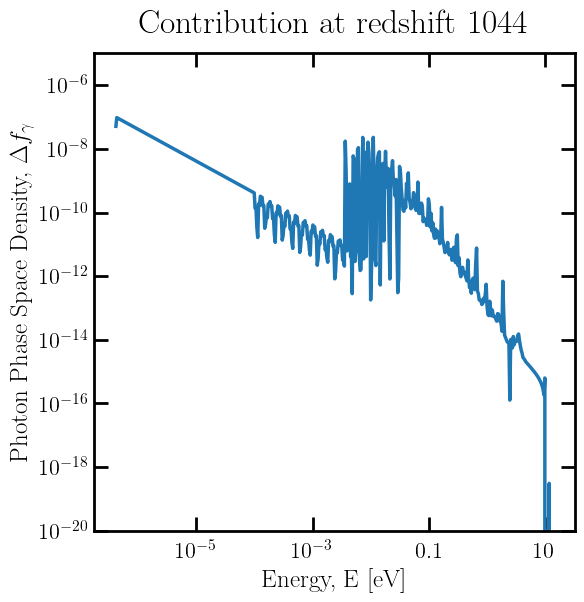

In [1124]:
plt.figure()
plt.loglog()

ind=66

# plt.plot(eng, tmp2['distortions'][ind].dNdE)
# plt.ylabel('dndE')

plt.ylim([1e-20, 1e-5])
plt.plot(eng, np.abs(prefac * tmp2['distortions'][ind].dNdE * tmp2['rs'][ind]**3))
plt.ylabel('Photon Phase Space Density, $\Delta f_{\gamma}$')

plt.xlabel('Energy, E [eV]')
plt.title('Contribution at redshift '+str(round(tmp2['rs'][ind])))

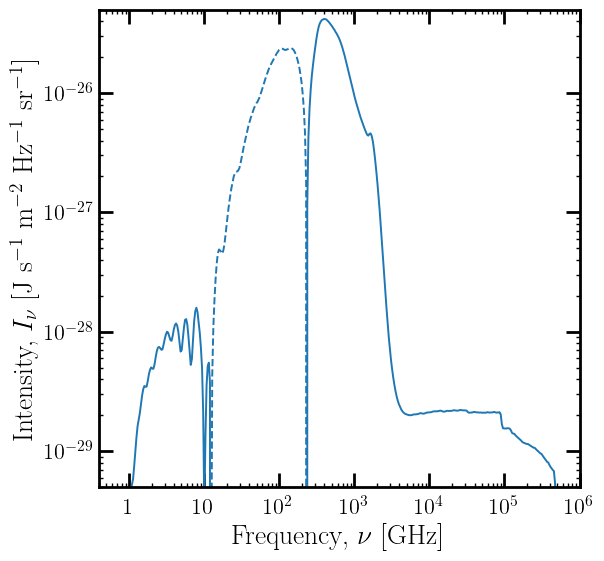

In [1099]:
plt.figure()
ax = plt.gca()
plot_distortion(ax, tmp2, ylim=[5e-30,5e-26])

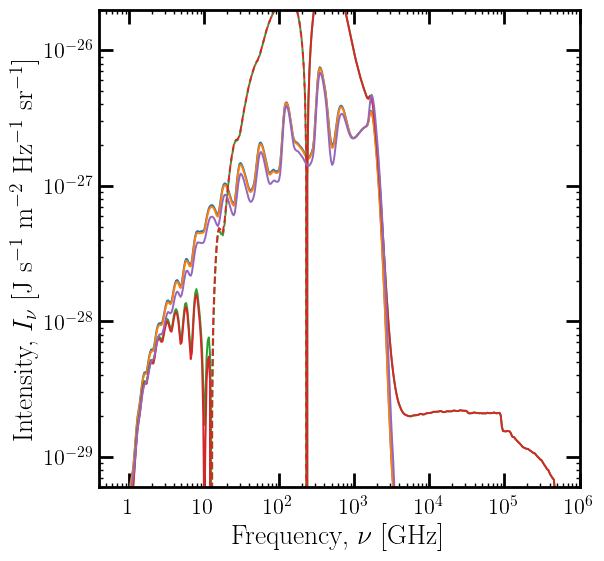

In [1078]:
plt.figure()
ax = plt.gca()

plot_distortion(ax, tmp1)  # not reprocessed, no DM
plot_distortion(ax, tmp)  # reprocessed, no DM
plot_distortion(ax, tmp0)  # not reprocessed, DM
plot_distortion(ax, tmp2)  # reprocessed, DM
plot_distortion(ax, tmp3)  # reprocessed, no DM, fixed mask

In [1054]:
nmax=100
run100_0 = main.evolve(
    DM_process='decay', mDM=10**6.01,
    lifetime=2.7e24*1e20,
    primary='elec_delta',
    start_rs = 2e3, high_rs = 1.555e3, end_rs=700,
    coarsen_factor=cf, backreaction=True,
    distort=True,
    nmax=nmax,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=False,
    cross_check=False
)

  0%|          | 0/66.0 [00:00<?, ?it/s]

In [1282]:
%autoreload
nmax=20
run100_2 = main.evolve(
    DM_process='decay', mDM=10**6.01,
    lifetime=2.7e24*1e20,
    primary='elec_delta',
    start_rs = 2e3, high_rs = 1.555e3, end_rs=700,
    coarsen_factor=cf, backreaction=True,
    distort=True,
    nmax=nmax,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=True,
    cross_check=False
)

  0%|          | 0/66.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.00000000e+00 9.94470821e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.70873631e-08 1.22177628e-08
 2.27077087e-08 3.44675479e-08]
[0.00000000e+00 1.33415246e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.46865442e-08 2.41291309e-08
 4.01320171e-08 3.52804055e-08]
[0.00000000e+00 1.90507713e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.70037208e-08 3.42312992e-08
 5.55088187e-08 4.69235515e-08]
[0.00000000e+00 3.18596417e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.28816370e-08 4.85880139e-08
 6.96562303e-08 7.15306525e-08]
[0.00000000e+00 5.11021270e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.06311719e-07 6.93847720e-08
 1.04599602e-07 9.73622362e-08]
[0.00000000e+00 8.31829809e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.59969742e-07 9.84184051e-08
 1.49962005e-07 1.39817926e-07]
[0.00000000e

KeyboardInterrupt: 

In [16]:
def download_plot(file):
    with open('/Users/gregoryridgway/Desktop/Webplot_distortion/'+file+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        goods = []
        for row in reader:
            goods.append([float(r) for r in row])
            
        goods = np.array(goods)

    return goods

BB_BF_jens = download_plot('BB_plus_BF_dist')
n10_data = download_plot('n10')

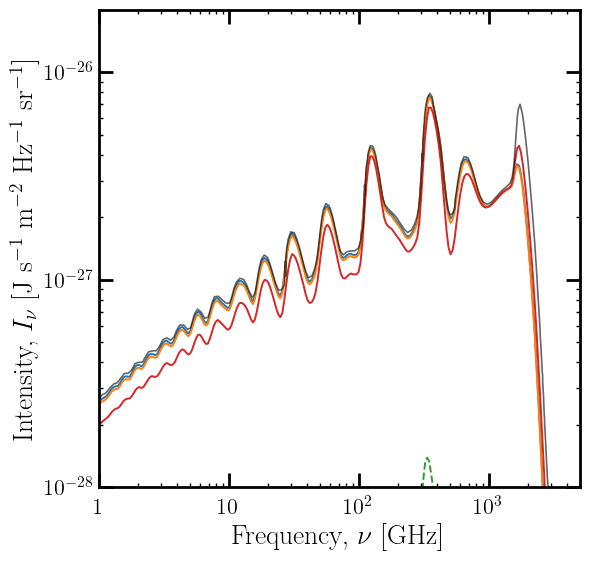

In [1281]:
plt.figure()
ax = plt.gca()

xlim = [1,5e3]
ylim = [1e-28, 2e-26]

plot_distortion(ax, run100_0, xlim=xlim, ylim=ylim)
plot_distortion(ax, run100_1, xlim=xlim, ylim=ylim)
plot_distortion(ax, run100_1, run100_0, diff=True, xlim=xlim, ylim=ylim)
plot_distortion(ax, run100_2, xlim=xlim, ylim=ylim)

plt.plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
         linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)
# plot_distortion(ax, run100_1)

In [1852]:
%autoreload
nmax=10
end_rs = 700
cf = 16

crap0 = main.evolve(
    DM_process='decay', mDM=10**6.01,
    lifetime=2.7e24*1e20,
    primary='elec_delta',
    start_rs = 2e3, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf, backreaction=True,
    distort=True,
    nmax=nmax,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=True,
    cross_check=False
)

  0%|          | 0/66.0 [00:00<?, ?it/s]

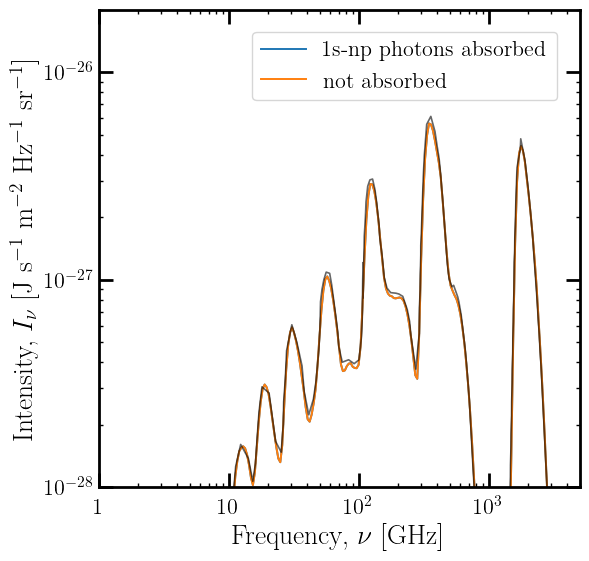

In [1853]:
plt.figure()
ax = plt.gca()

xlim = [1,5e3]
ylim = [1e-28, 2e-26]

plot_distortion(ax, crap0, xlim=xlim, ylim=ylim, label='1s-np photons absorbed', first=False)
plot_distortion(ax, crap, xlim=xlim, ylim=ylim, label='not absorbed', first=False)
plt.legend()

plt.plot(n10_data[:,0], n10_data[:,1], color='k',
         linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)

## Iterations at $n_{max}=100$

In [873]:
for i in np.arange(5):
    mDM = iter1[100][0][i]
    run = iter1[100][1][i]
    param = param_bound(mDM, DM_process, pri)

#     beta_func = interp1d(np.log(run['rs']), np.log(run['MLA'][1][1:]))
#     def beta_MLA(rs):
#         return np.exp(beta_func(np.log(rs)))

#     MLA_funcs = np.array([
#         interp1d(run['rs'], run['MLA'][0][1:]),
#         beta_MLA
#     ])

    f_raw = {key: interp1d(run['rs'], run['f'][key],
                           bounds_error=False, fill_value = (0,0))
             for key in run['f'].keys()}

    def f_H_ion(rs, xHI, xHeI, xHeII):
        return f_raw['H ion'](rs)
    def f_heat(rs, xHI, xHeI, xHeII):
        return f_raw['heat'](rs)
    def f_H_exc(rs, xHI, xHeI, xHeII):
        return f_raw['Lya'](rs)

    def rate_func_eng(rs):
        return phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=param, sigmav=param)

#     rs_vec = np.exp(np.arange(np.log(3e3),np.log(5),-.001*16))

    out = tla.get_history(
        rs_list, high_rs=np.inf,
        f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
        injection_rate=rate_func_eng,
        recfast_TLA=True,
#         alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
        mxstep=10000, rtol=1e-8
    )
    iter0.append(out[:,1])

In [871]:
iter0, iter1, iter2 = [], {}, {}

In [917]:
pri = 'elec'
DM_process = 'decay'

for nmax in [10,100]:
    iter1[nmax] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
        'iter1_'+pri+'_'+DM_process+'_nmax'+str(nmax)+'_endrs5.dat','rb'))

    iter2[nmax] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
        'iter2_'+pri+'_'+DM_process+'_nmax'+str(nmax)+'_endrs5.dat','rb'))
    
rs_list = iter1[100][1][i]['rs']

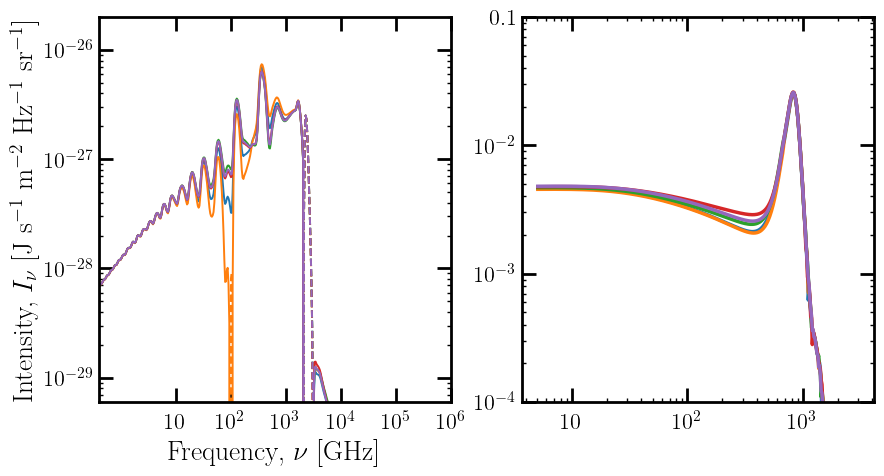

In [913]:
f, axarr = plt.subplots(1,2, figsize=(10,5))
axarr[0].loglog()
axarr[1].loglog()

axarr[1].set_ylim([1e-4,.1])

# i=0
for i in np.arange(5):
# axarr[0].plot(rs_list, iter0[i])
# axarr[0].plot(rs_list, iter1[100][1][i]['x'][:,0], ':')
# axarr[0].plot(rs_list, iter2[100][1][i]['x'][:,0], '--')
# axarr[0].plot(rs_list, phys.xHII_std(rs_list))

# axarr[0].plot(rs_list, np.abs(iter1[100][1][i]['x'][:,0]/iter0[i]-1))
# axarr[0].plot(rs_list, np.abs(iter2[100][1][i]['x'][:,0]/iter1[100][1][i]['x'][:,0]-1))
#     axarr[0].plot(iter1[10][1][i]['rs'], 
#                   np.abs(iter1[10][1][i]['x'][:,0]/iter0[10][1][i]['x'][:,0]-1),
#                  color='C'+str(i), linewidth=1.2, alpha=0.8, linestyle='--')

#     axarr[0].plot(rs_list, 
#                   np.abs(iter1[100][1][i]['x'][:,0]/iter0[i]-1),
#                  color='C'+str(i), linestyle=':')
    
    plot_distortion(axarr[0], iter1[100][1][i], diff=False)
#     plot_distortion(axarr[1], iter2[100][1][i], diff=False)
    
    axarr[1].plot(rs_vec, 
                  np.abs(iter2[100][1][i]['x'][:,0]/iter1[100][1][i]['x'][:,0]-1),
                 color='C'+str(i))

In [1811]:
iter_newRates = []
# nmax=10

for i in range(5):
    iter_newRates.append(pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
        'iter'+str(i)+'_'+pri+'_'+DM_process+'_nmax10_endrs5.dat','rb')))

1
2
3


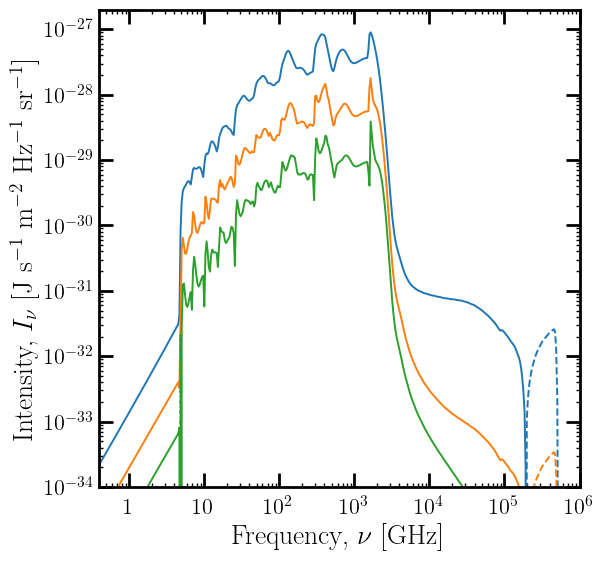

In [1812]:
plt.figure()
ax = plt.gca()
m_ind = 0

for i in range(1,4):
    print(i)
    plot_distortion(ax, iter_newRates[i+1][1][m_ind], iter_newRates[i][1][m_ind],
                    diff=True, ylim=[1e-34,2e-27])
#     plot_distortion(ax, iter_newRates[0][1][1], color='C1')
#     plot_distortion(ax, iter_newRates[0][1][2], color='C2')
#     plot_distortion(ax, iter_newRates[0][1][3], color='C3')
    
# plt.plot(n10_data[:,0], n10_data[:,1], color='k',
#          linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)

# $2s \to 1s$

In [1444]:
%autoreload
# distortion when full equilibrium is satisfied (should be zero)

rs = 1500
nH, nB = np.array([phys.nH, phys.nB]) * rs**3
Tr = phys.TCMB(rs)

n1s = phys.xHI_std(rs)
n2s = np.exp(-phys.lya_eng/Tr) * n1s #+ 1e-5

def f_gamma(eng):
    return atomic.f_BB(eng, phys.TCMB(rs))

atomic.N_2s1s(eng_tmp, f_gamma, n2s, n1s)/nB

array([-1.12577578e-34,  1.56663050e-33, -5.09792934e-33, -2.45680445e-33,
       -2.36232210e-33, -3.23490828e-33, -3.20633524e-33, -3.57446766e-33,
        7.52215765e-34,  8.11659693e-34,  0.00000000e+00, -6.23212407e-33,
        4.62124815e-33, -7.64137903e-33, -7.31410832e-33, -1.73014237e-33,
       -1.78417235e-33, -3.20996334e-33, -3.76151875e-33,  3.60742727e-33,
       -1.00662391e-32,  1.50116582e-33, -3.56372231e-33, -5.68952302e-33,
       -6.82255079e-33, -5.31889726e-33,  2.69249703e-34,  2.17869008e-33,
        2.75218767e-34, -8.33729715e-33, -2.80420961e-34, -8.48285869e-33,
       -7.97836955e-33, -4.01755551e-33, -2.88848321e-34, -3.77764489e-33,
       -4.67508527e-33, -4.40500899e-33, -3.83520072e-33, -8.59098523e-33,
       -2.97346593e-34,  2.98335215e-34, -4.18892537e-33, -4.79951498e-33,
        3.00618973e-34, -3.91505529e-33, -3.92064526e-33,  0.00000000e+00,
       -3.62548421e-33, -4.23122334e-33, -4.83567385e-33, -4.53182719e-33,
       -4.52859956e-33, -

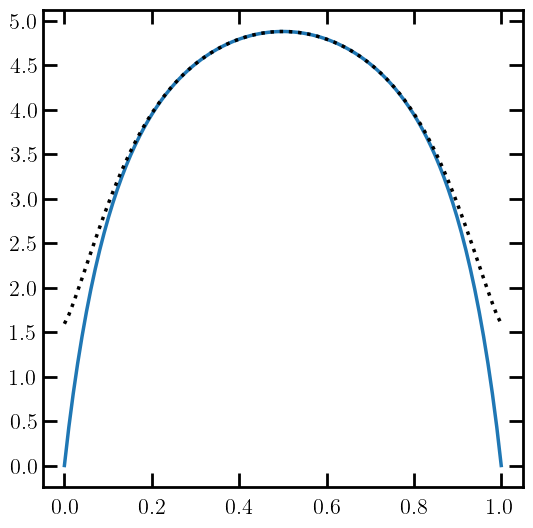

In [1445]:
%autoreload

# Reproduce Jens + Sunyaev's plot
eng_tmp = np.linspace(.001, phys.lya_eng-.001, 100)

plt.figure()

# plt.plot(eng_tmp/phys.lya_eng, phys.dNdE_2s1s(eng_tmp)*phys.lya_eng)
plt.plot(eng_tmp/phys.lya_eng, atomic.phi(eng_tmp/phys.lya_eng))
plt.plot(
    eng_tmp/phys.lya_eng, 
    atomic.phi(eng_tmp/phys.lya_eng) * 
    (1 + f_gamma(eng_tmp)) * 
    (1 + f_gamma(phys.lya_eng - eng_tmp)), 
    'k:'
)

ax=plt.gca()
ax.set_yticks(np.arange(0,5.5,.5));

In [1438]:
%autoreload
# Our numerical integral is correct
for rs in [1, 10, 100, 1500, 3000]:
    def f_gamma(eng):
        return atomic.f_BB(eng, phys.TCMB(rs))

    print(rs, atomic.A_2s1s(f_gamma, use_quad=True)/atomic.A_2s1s(f_gamma)-1)

1 -1.4764975464487406e-07
10 5.383279244597361e-08
100 -6.6366563356012875e-09
1500 -9.676214474119149e-08
3000 -1.7846317645897614e-07


In [1442]:
%autoreload
# Detailed Balance

R = atomic.populate_radial(nmax)
BB, BB_2s1s = atomic.populate_bound_bound(nmax, phys.TCMB(rs), R)

print(atomic.A_2s1s(f_gamma, 'up')/atomic.A_2s1s(f_gamma, 'dn')/np.exp(
    -phys.lya_eng/phys.TCMB(rs))-1)

BB_2s1s['dn']/BB_2s1s['up'] * np.exp(-phys.lya_eng/phys.TCMB(rs))-1

6.661338147750939e-16


-6.661338147750939e-16

In [1397]:
# Can we calcuate the 2s1s rate?
def f_gamma(E):
    return 0
phys.width_2s1s_H/atomic.A_2s1s(f_gamma)-1

0.00044803520381409

In [1446]:
%autoreload

# Test out the distortion emitted

x1s = phys.xHI_std(rs)
boltz = np.exp(-phys.lya_eng/phys.TCMB(rs))
x2s = x1s * (boltz + .001)

amp_2s1s = phys.nH/phys.nB * phys.width_2s1s_H * (x2s - x1s * boltz)
amp_2s1s * spec_2s1s.N/atomic.N_2s1s(spec_2s1s.eng, None, x2s, x1s)

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:61: RuntimeWarning: invalid value encountered in power
  res = C * (w * (1 - 4**gam * w**gam) + alp * w**(bet + gam) * 4**gam)
/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_50782/3813347546.py:10: RuntimeWarning: divide by zero encountered in true_divide
  amp_2s1s * spec_2s1s.N/atomic.N_2s1s(spec_2s1s.eng, None, x2s, x1s)
/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_50782/3813347546.py:10: RuntimeWarning: invalid value encountered in true_divide
  amp_2s1s * spec_2s1s.N/atomic.N_2s1s(spec_2s1s.eng, None, x2s, x1s)


array([0.51496296, 1.00099948, 1.00099948, 1.00099948, 1.00099948,
       1.00099948, 1.00099948, 1.00099948, 1.00099948, 1.00099948,
       1.00099948, 1.00099948, 1.00099948, 1.00099948, 1.00099948,
       1.00099948, 1.00099948, 1.00099948, 1.00099948, 1.00099948,
       1.00099948, 1.00099948, 1.00099948, 1.00099948, 1.00099948,
       1.00099948, 1.00099948, 1.00099948, 1.00099948, 1.00099948,
       1.00099948, 1.00099948, 1.00099948, 1.00099948, 1.00099948,
       1.00099948, 1.00099948, 1.00099948, 1.00099948, 1.00099948,
       1.00099948, 1.00099948, 1.00099948, 1.00099948, 1.00099948,
       1.00099948, 1.00099948, 1.00099948, 1.00099948, 1.00099948,
       1.00099948, 1.00099948, 1.00099948, 1.00099948, 1.00099947,
       1.00099947, 1.00099947, 1.00099947, 1.00099947, 1.00099947,
       1.00099947, 1.00099947, 1.00099947, 1.00099947, 1.00099947,
       1.00099947, 1.00099947, 1.00099947, 1.00099947, 1.00099947,
       1.00099947, 1.00099947, 1.00099947, 1.00099947, 1.00099

In [1423]:
%autoreload
start_rs = 2000
end_rs = 800
nmax = 30

run_new2s1s = main.evolve(
    DM_process='decay', mDM=2e8,
    lifetime=1e50,
    primary='phot_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf,
    distort=True, recfast_TLA=True,
    fexc_switch=False, 
    reprocess_distortion=False, 
    nmax=nmax,
    rtol=1e-6
)

  0%|          | 0/58.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:61: RuntimeWarning: invalid value encountered in power
  res = C * (w * (1 - 4**gam * w**gam) + alp * w**(bet + gam) * 4**gam)


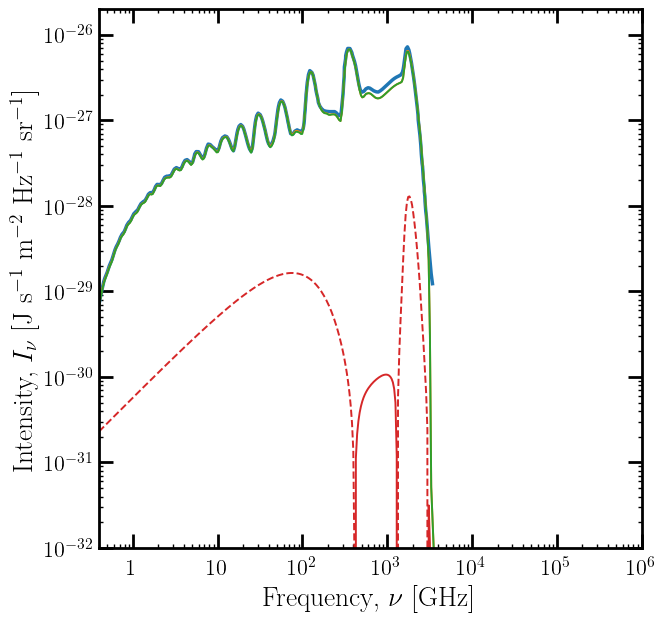

In [1424]:
### Show's that Wenzer's new code is correct
# jens_data = download_plot('Full_Distortion')

plt.figure(figsize=(7, 7))
ax = plt.gca()
ax.loglog()

ax.plot(jens_data[:,0], jens_data[:,1])
plot_distortion(ax, run_new2s1s)
plot_distortion(ax, run_old2s1s)
plot_distortion(ax, run_old2s1s, run_new2s1s, diff=True, ylim=[1e-32,2e-26])

# y distortion

In [1615]:
phys.x_std(3e3)

6.912524408451516e-10

In [1616]:
%autoreload
rtol=1e-10

mDM = 2e8
DM_process = 'decay'
pri = 'elec'

param = param_bound(mDM, DM_process, pri)

high_rs = np.inf
rs_vec = np.exp(np.arange(np.log(3e3), np.log(5), -.001*16))

baseline_history = tla.get_history(rs_vec, high_rs=high_rs, rtol=rtol)

DM_history = tla.get_history(
    rs_vec, high_rs=high_rs,
    baseline_f=True,
    inj_particle=pri, DM_process=DM_process,
    mDM=mDM, lifetime=param, sigmav=param,
    rtol=rtol
)

In [1620]:
xe_vec = baseline_history[:,1] + phys.x_std(rs_vec, 'HeII')
rho_CMB = 4 * phys.stefboltz/phys.c * phys.TCMB(rs_vec)**4
nH_vec = phys.nH * rs_vec**3
ne_vec = nH_vec * xe_vec
cv = 3/2 * nH_vec * (1 + phys.chi + xe_vec)
Gamma_t = phys.thomson_xsec * ne_vec * phys.c
Gamma_c = 4 * Gamma_t * rho_CMB / (phys.me * cv)

dEdVdt_inj = (
    phys.f_std(mDM, rs_vec, pri, DM_process, False, 'heat') *
    phys.inj_rate(DM_process, rs_vec, mDM, param, param)
)

# DM_deviation = dEdVdt_inj / (cv * Gamma_c)

DM_deviation = dEdVdt_inj * phys.me / (4 * Gamma_t * rho_CMB)

In [1630]:
(baseline_history[:,0]/T_CMB-1)/(phys.hubble(rs_vec)/Gamma_c)

array([ 0.00000000e+00, -1.35088749e+00, -1.35085810e+00, -1.35092812e+00,
       -1.35093415e+00, -1.35117096e+00, -1.35401541e+00, -1.36014591e+00,
       -1.33706586e+00, -1.29902705e+00, -1.35088720e+00, -1.35088807e+00,
       -1.35088380e+00, -1.35087227e+00, -1.35080924e+00, -1.34967599e+00,
       -1.35050455e+00, -1.35143940e+00, -1.35262499e+00, -1.35402968e+00,
       -1.34405214e+00, -1.36114873e+00, -1.35088264e+00, -1.35088255e+00,
       -1.35089414e+00, -1.35088381e+00, -1.35088247e+00, -1.35089446e+00,
       -1.35082731e+00, -1.35088216e+00, -1.35089148e+00, -1.35087785e+00,
       -1.35086808e+00, -1.35087396e+00, -1.35084049e+00, -1.35094568e+00,
       -1.35085503e+00, -1.35082506e+00, -1.35067692e+00, -1.35077519e+00,
       -1.35070910e+00, -1.35071040e+00, -1.35638412e+00, -1.36004594e+00,
       -1.36551971e+00, -1.37309840e+00, -1.38297502e+00, -1.39521587e+00,
       -1.40982794e+00, -1.42671718e+00, -1.44565895e+00, -1.46661068e+00,
       -1.48950239e+00, -

In [1634]:
phys.Tm_std(rs_vec)

NameError: free variable 'rs_vec' referenced before assignment in enclosing scope

In [1643]:
tmp = pickle.load(open(config.data_path+'/std_soln_He.p', 'rb'))

In [1647]:
tmp[1]

array([7.04467733e-01, 7.04232739e-01, 7.03997916e-01, ...,
       1.68340917e-05, 7.49736091e-06, 1.87498546e-06])

In [1625]:
DM_deviation/T_CMB

array([1.13901146e-14, 3.00036654e-11, 4.17982831e-11, 5.11588492e-11,
       5.94121043e-11, 6.72334843e-11, 7.49708018e-11, 8.28003873e-11,
       9.08419898e-11, 9.92201125e-11, 1.08080014e-10, 1.17495981e-10,
       1.27558424e-10, 1.38444961e-10, 1.50245478e-10, 1.62968250e-10,
       1.76682661e-10, 1.91549608e-10, 2.07763243e-10, 2.25246014e-10,
       2.44077850e-10, 2.64438465e-10, 2.86660467e-10, 3.10601555e-10,
       3.36356643e-10, 3.63684773e-10, 3.91642169e-10, 4.22152429e-10,
       4.54779072e-10, 4.89257341e-10, 5.28368641e-10, 5.69255798e-10,
       6.11641623e-10, 6.54896625e-10, 7.20291628e-10, 7.89130388e-10,
       8.60940090e-10, 9.36947898e-10, 1.01987243e-09, 1.10943944e-09,
       1.20570646e-09, 1.31209308e-09, 1.44119982e-09, 1.58529694e-09,
       1.75425705e-09, 1.95534499e-09, 2.19774534e-09, 2.49042300e-09,
       2.84095715e-09, 3.26348260e-09, 3.77417222e-09, 4.39851014e-09,
       5.15331656e-09, 6.06446258e-09, 7.17517320e-09, 8.53949231e-09,
      

Text(0, 0.5, 'Temperature [eV]')

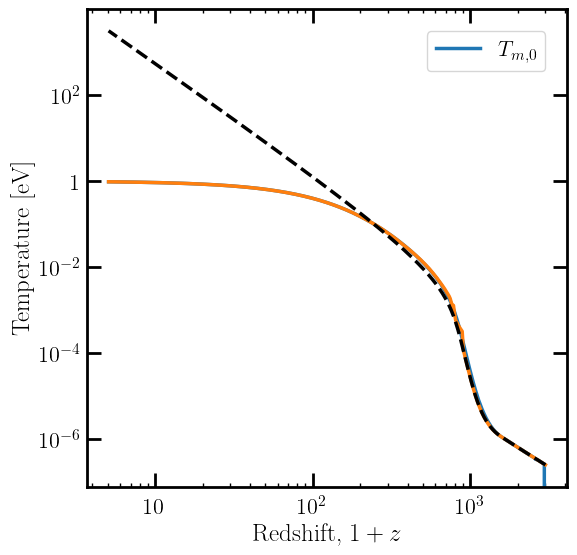

In [1641]:
%autoreload
plt.figure()
# plt.xscale('log')
plt.loglog()
# plt.xlim([200, 3e3])
# plt.ylim([-.1, .1])

mask = rs_vec>500

plt.plot(rs_vec, -(baseline_history[:,0]/T_CMB-1), label=r'$T_{m,0}$')
plt.plot(rs_vec, -(phys.Tm_std(rs_vec)/T_CMB-1))
# plt.plot(rs_vec[mask], -(DM_history[:,0]/T_CMB-1)[mask], label=r'$T_{m,0}$')
plt.plot(rs_vec, (1.35*phys.hubble(rs_vec)/Gamma_c), 'k--')
# plt.plot(rs_vec[mask], -(DM_deviation/T_CMB-phys.hubble(rs_vec)/Gamma_c)[mask])

# plt.plot(rs_vec, (DM_history[:,0]-baseline_history[:,0]),
#          label=r'$\Delta T$ numerical')
# plt.plot(rs_vec, (DM_deviation), label=r'$\Delta T$ analytic')

plt.legend()
plt.xlabel('Redshift, $1+z$')
plt.ylabel('Temperature [eV]')

Text(0, 0.5, 'y parameter')

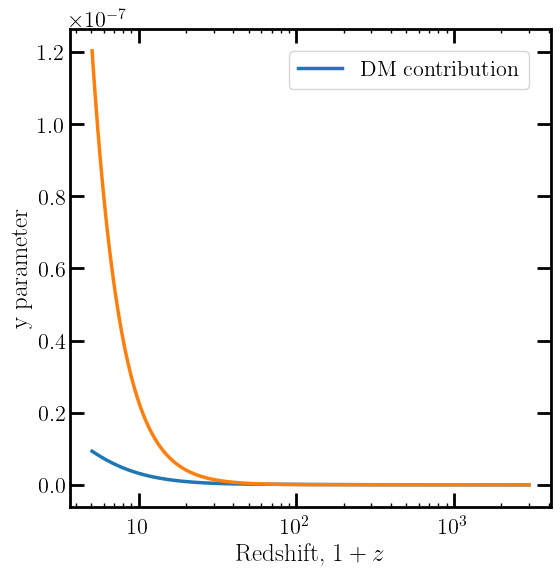

In [1113]:
plt.figure()
# plt.loglog()
plt.xscale('log')

T_CMB = phys.TCMB(rs_vec)
prefac = Gamma_t/phys.me / phys.hubble(rs_vec)

# plt.plot(rs_vec, (baseline_history[:,0]-T_CMB)/phys.kB, label=r'$T_{m,0}$')
# plt.plot(rs_vec, (DM_history[:,0]-T_CMB)/phys.kB, label=r'$T_m$ w/ DM')

# plt.plot(rs_vec, -prefac * (baseline_history[:,0]-T_CMB), label=r'$T_{m,0}$')
# plt.plot(rs_vec, prefac * (DM_history[:,0]-T_CMB), label=r'$T_m$ w/ DM')

plt.plot(rs_vec, prefac * (DM_history[:,0]-baseline_history[:,0]), label=r'DM contribution')
plt.plot(rs_vec, dEdVdt_inj / (4 * rho_CMB * phys.hubble(rs_vec)))

# plt.plot(rs_vec, baseline_history[:,0]/T_CMB-1, label=r'$T_{m,0}$')
# plt.plot(rs_vec, DM_history[:,0]/T_CMB-1, label=r'$T_m$ w/ DM')

# plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB - T_CMB, 'k--', label=r'$T_{CMB}$')

plt.legend()
plt.xlabel(r'Redshift, $1+z$')
# plt.ylabel(r'Temperature, T [K]')
plt.ylabel(r'y parameter')

## 21cm Results

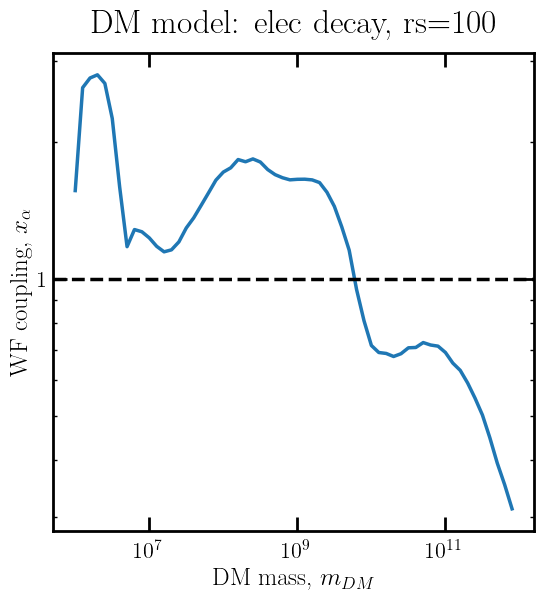

In [1615]:
rs=100
DH_switch=True

if not DH_switch:
    chi_alpha = 1/6.
    xi = 1e-24  # s^-1
    dE_dVdt_dep = chi_alpha * xi * phys.mp * phys.nB * rs**3
    
else:
    pri = 'elec'
    DM_process = 'decay'
    if pri == 'elec':
        log10_mstart = np.log10(2*phys.me + 1e3)
    else:
        log10_mstart = 4
    mDM = 10**np.arange(log10_mstart, 12, .1)
    param = param_bound(mDM, DM_process, pri)
    dE_dVdt_inj = phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=param, sigmav=param)
    dE_dVdt_dep = phys.f_std(mDM, rs, pri, DM_process, False, 'exc') * dE_dVdt_inj

ans = 1.81e11 / rs * phys.c/(4*np.pi) /(
        hplanck * phys.lya_freq**2) / phys.hubble(rs) * dE_dVdt_dep
    
if not DH_switch:
    print(rs, ans)
else:
    plt.figure()
    plt.loglog()
    plt.plot(mDM, ans)
    plt.xlabel(r'DM mass, $m_{DM}$')
    plt.ylabel(r'WF coupling, $x_\alpha$')
    plt.title('DM model: '+pri+' '+DM_process+', rs='+str(rs))
    
    plt.axhline(1, color='k', linestyle='--')